In [1]:
from process_signals import *
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='The test statistic is outside of the range of p-values')
warnings.filterwarnings('ignore', category=UserWarning, message='No frequency information was provided, so inferred frequency D will be used.')

/home/iann/Desktop/Risk/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
if not os.path.exists('img'):
    os.makedirs('img')

In [3]:
data = pd.read_csv('./data/consumo.csv', encoding="utf-8", thousands=".", decimal=",")
print(data.shape)
data.head(7)

(3073, 15)


AÑO     MES     Fecha                Tipo día  GRAN BS.AS.  BUENOS AIRES  \
0  2017  ene-17  1/1/2017       Domingo o Feriado       6352.7        1472.3   
1  2017  ene-17  2/1/2017           Lunes habiles       6617.9        1779.4   
2  2017  ene-17  3/1/2017          Martes Habiles       6678.0        1889.0   
3  2017  ene-17  4/1/2017       Miercoles habiles       6427.0        1840.6   
4  2017  ene-17  5/1/2017          Jueves Habiles       5874.0        1770.9   
5  2017  ene-17  6/1/2017         Viernes habiles       5781.1        1801.1   
6  2017  ene-17  7/1/2017  Sabado o Semilaborable       6231.7        1862.7   

   CENTRO  LITORAL    CUYO  NOROESTE  NORESTE  COMAHUE  PATAGONICA  \
0  1134.4   1766.6   903.1    1602.1   1400.3    561.2       500.9   
1  1363.5   1963.9  1091.8    1627.6   1585.6    638.8       540.6   
2  1600.7   2036.3  1178.7    1806.5   1653.0    624.6       536.5   
3  1356.4   1756.6  1078.9    1759.9   1604.8    598.4       528.9   
4  1366.0   1848.4  1037.8    1403.5   1228.3    585.2       524.7   
5  1367.4   1929.8  1135.5    1354.6   1218.7    615.5       550.9   
6  1388.8   2042.9  1161.9    1425.7   1306.4    626.4       533.9   

   DEMANDA TOTAL  TEMPERATURA REFERENCIA MEDIA GBA °C  
0        15693.7                                 31.3  
1        17209.2                                 25.4  
2        18003.4                                 25.5  
3        16951.5                                 27.0  
4        15638.8                                 21.9  
5        15754.5                                 24.3  
6        16580.5                                 29.1

In [4]:
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')
data.set_index('Fecha', inplace=True)

# Verificación de datos nulos o faltantes

In [5]:
print(data.isnull().sum())
print('Datos totales', data.shape[0])
print('Cantidad de días', (data.index[-1] - data.index[0]).days)

AÑO                                    0
MES                                    0
Tipo día                               0
GRAN BS.AS.                            0
BUENOS AIRES                           0
CENTRO                                 0
LITORAL                                0
CUYO                                   0
NOROESTE                               0
NORESTE                                0
COMAHUE                                0
PATAGONICA                             0
DEMANDA TOTAL                          0
TEMPERATURA REFERENCIA MEDIA GBA °C    0
dtype: int64
Datos totales 3073
Cantidad de días 3072


In [6]:
 # Separamos todas las series de tiempo
apodos = ['AMBA', 'CABA', 'CENTRO', 'LITORAL', 'CUYO', 'NOESTE', 'NESTE', 'COMAHUE', 'PATAG', 'TOTAL']
series = {}
for col in ['GRAN BS.AS.','BUENOS AIRES','CENTRO','LITORAL','CUYO','NOROESTE','NORESTE','COMAHUE','PATAGONICA','DEMANDA TOTAL']:
    series[col] = {}
    series[col]['ORIGINAL'] = data[col].dropna()
    series[col]['APODO'] = apodos.pop(0)

# series = {}
# series['DEMANDA TOTAL'] = {}
# series['DEMANDA TOTAL']['ORIGINAL'] = data['DEMANDA TOTAL'].dropna()
# series['DEMANDA TOTAL']['APODO'] = 'TOTAL'

In [7]:
# Obtenemos la señal de consumo per cápita de cada región:
# poblacion = {
#     'AMBA': 17523996,
#     'CABA': 3121707,
#     'CENTRO': 3840905,
#     'LITORAL': 3544908 + 1425578,
#     'CUYO': 2043540 + 822853 + 542069 + 383865,
#     'NOESTE': 1731820 + 1440672 + 1060906 + 811611 + 429562,
#     'NESTE': 1278873 + 1212696 + 1129606 + 607419,
#     'COMAHUE': 710814 + 750768 + 361859,
#     'PATAG': 592621 + 337226 + 185732
# }
# poblacion['TOTAL'] = sum(poblacion.values())

# for col, serie in series.items():
#     if col != 'DEMANDA TOTAL':
#         serie['CONSUMO_PER_CAPITA'] = serie['MA30'] / poblacion[serie['APODO']]
#         # plot_series(serie['CONSUMO_PER_CAPITA'], title=f"{col} - Consumo per cápita", ymin=0, ymax=serie['CONSUMO_PER_CAPITA'].max() * 1.1)

# # Ploteo todas las series per cápita en una sola figura
# plt.figure(figsize=(12, 6))
# for col, serie in series.items():
#     if col != 'DEMANDA TOTAL':
#         plt.plot(serie['MA30'], label=serie['APODO'])
# plt.title('Consumo per cápita por región')
# plt.xlabel('Fecha')
# plt.ylabel('Consumo per cápita (kWh)/hab')
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

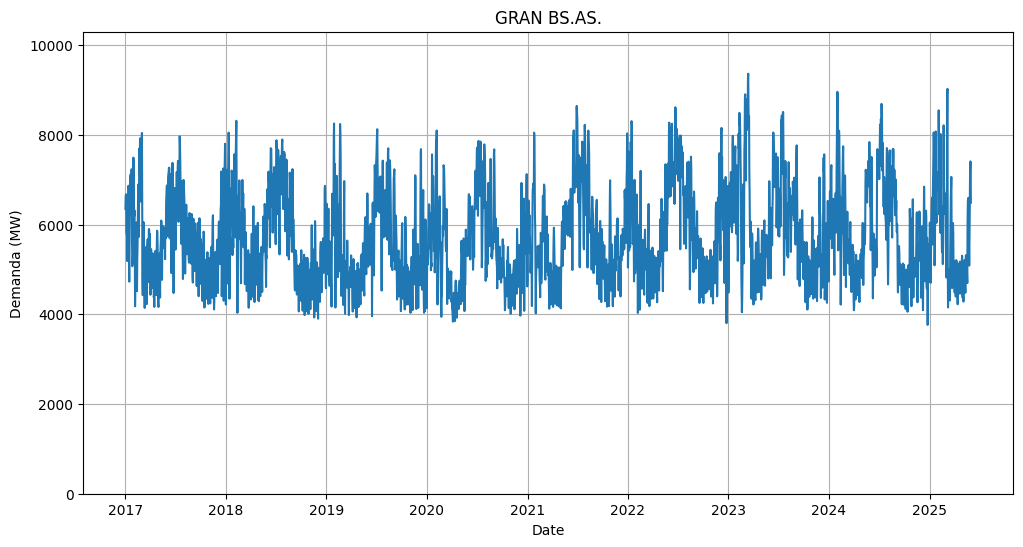

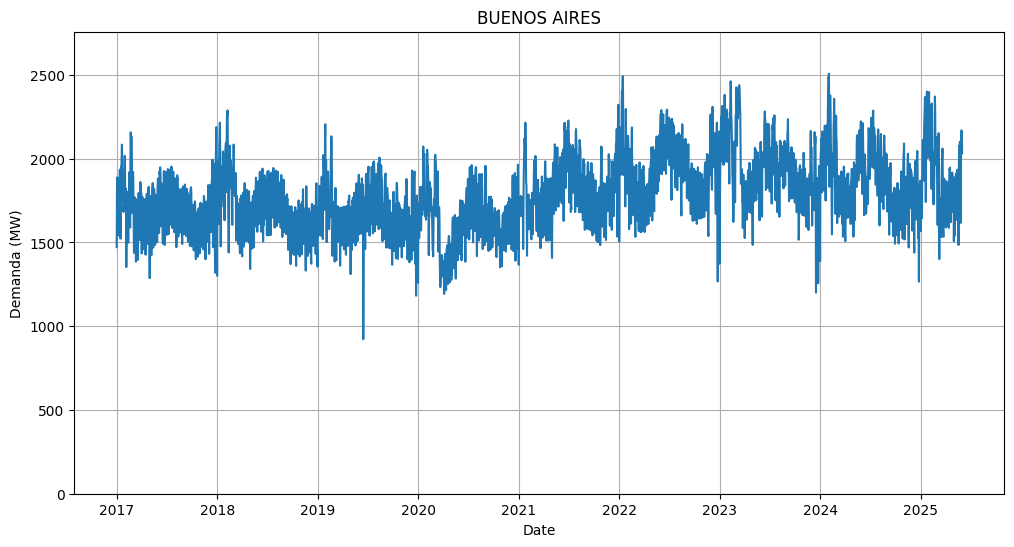

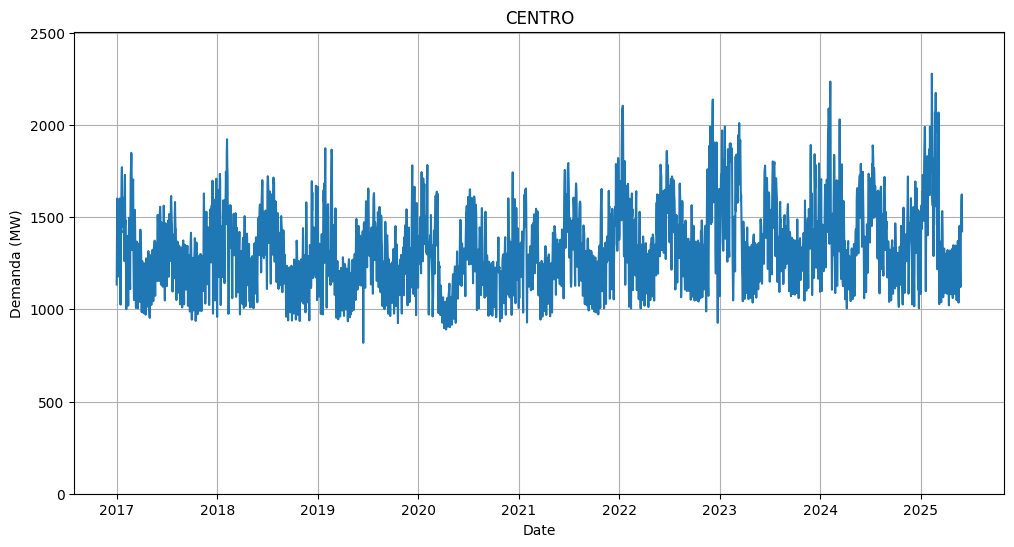

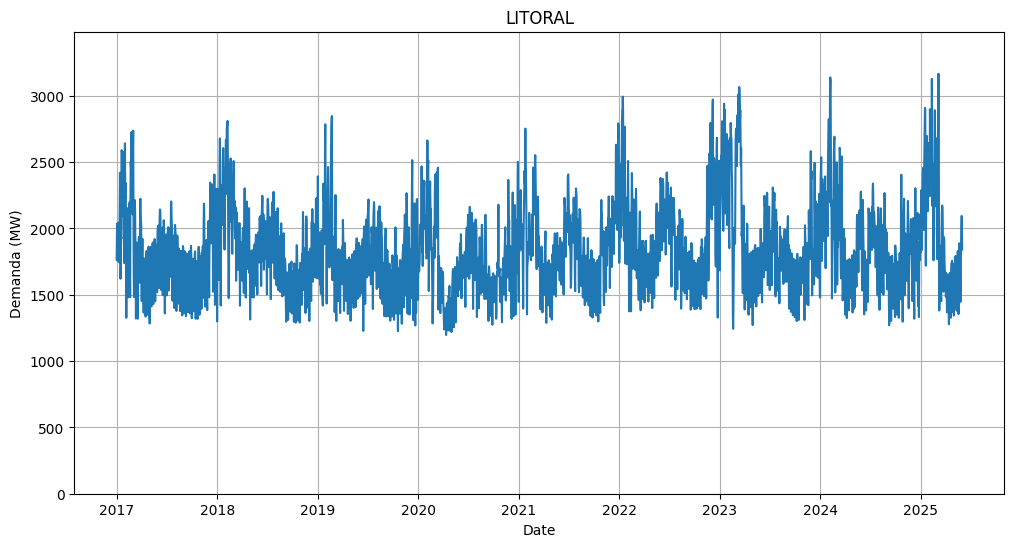

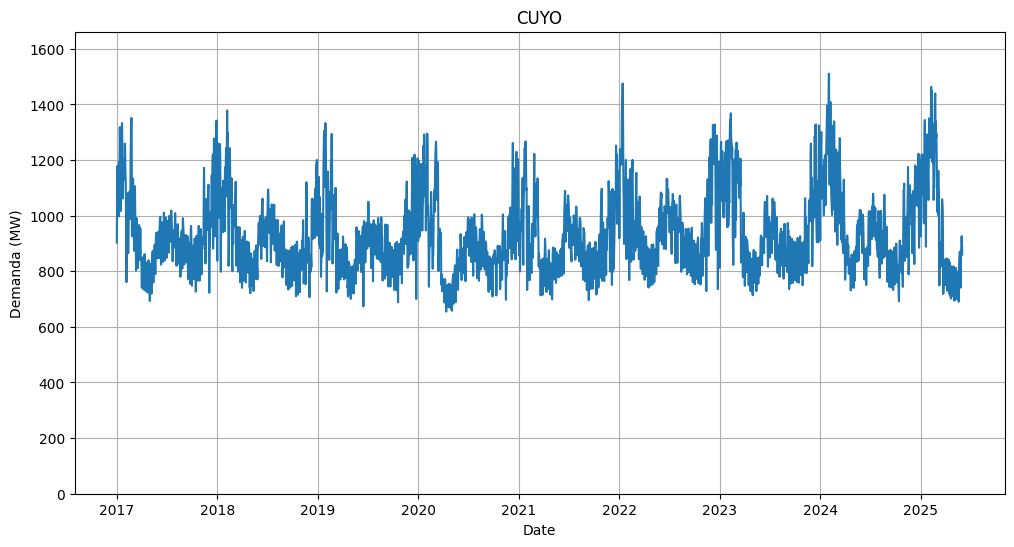

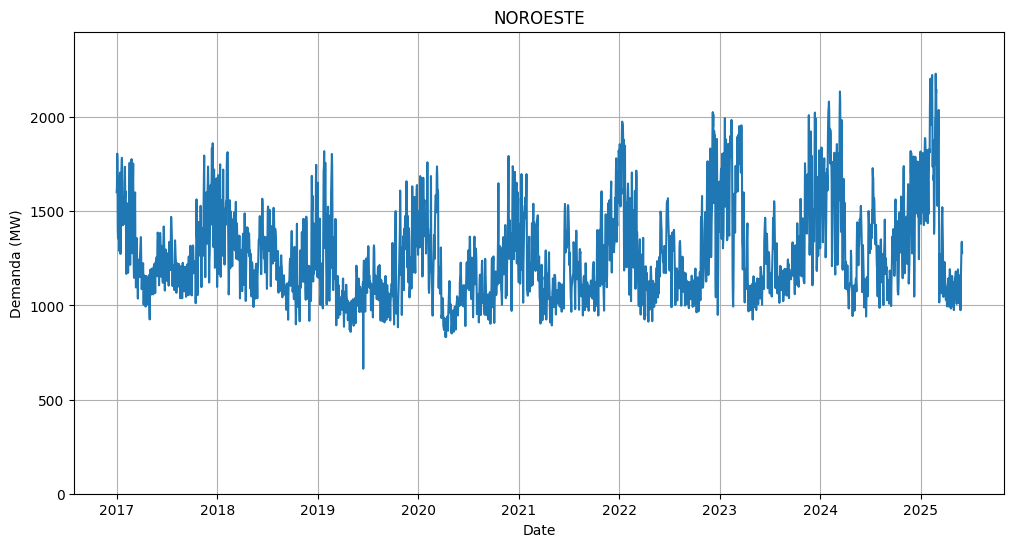

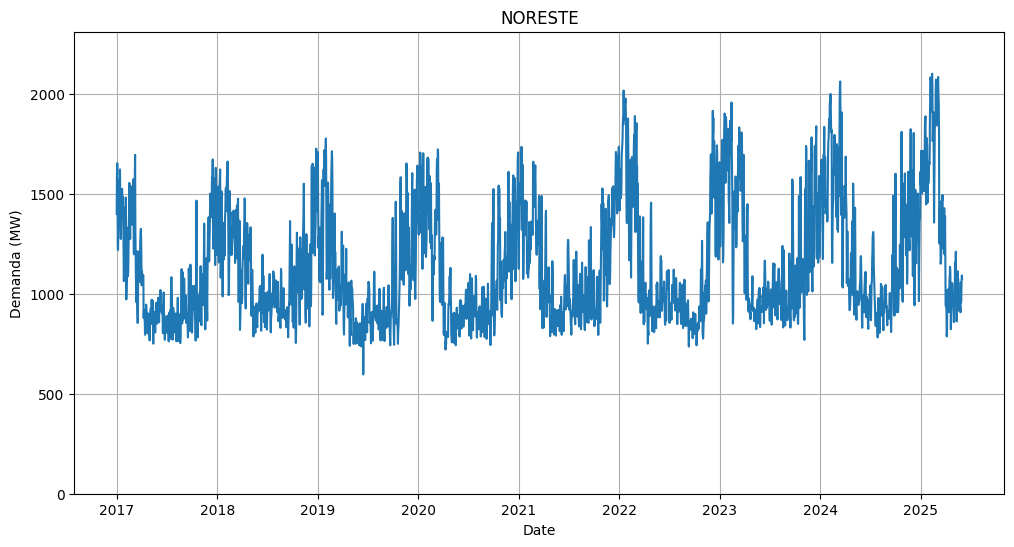

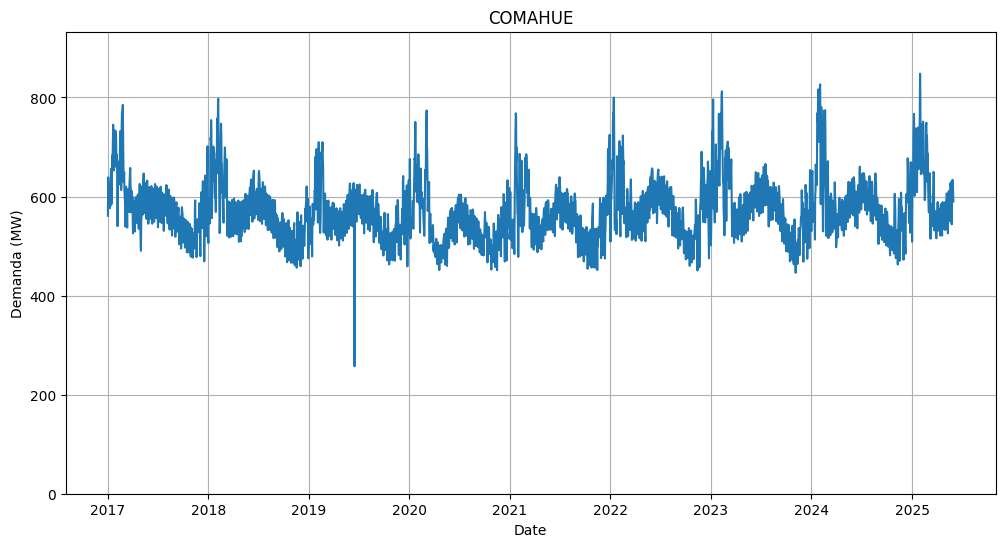

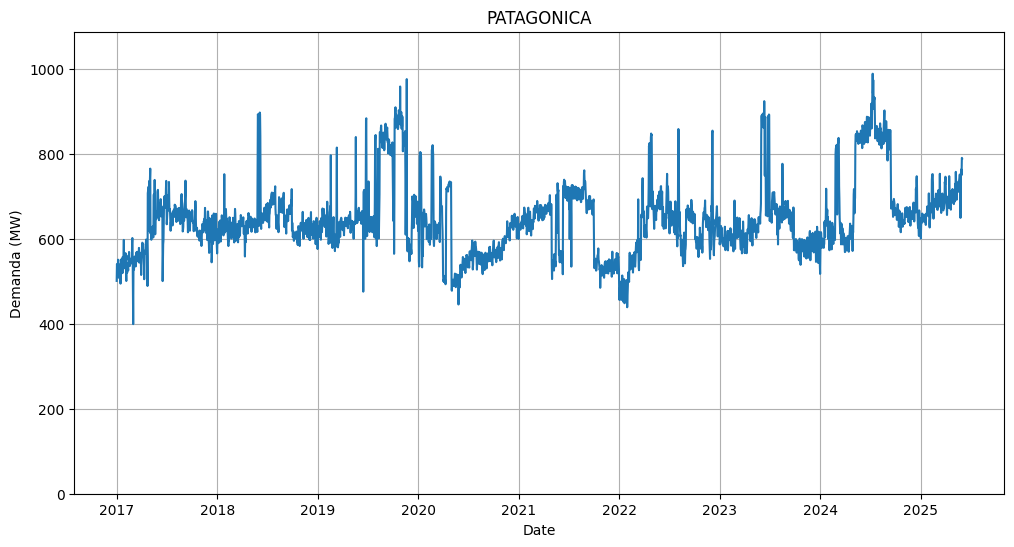

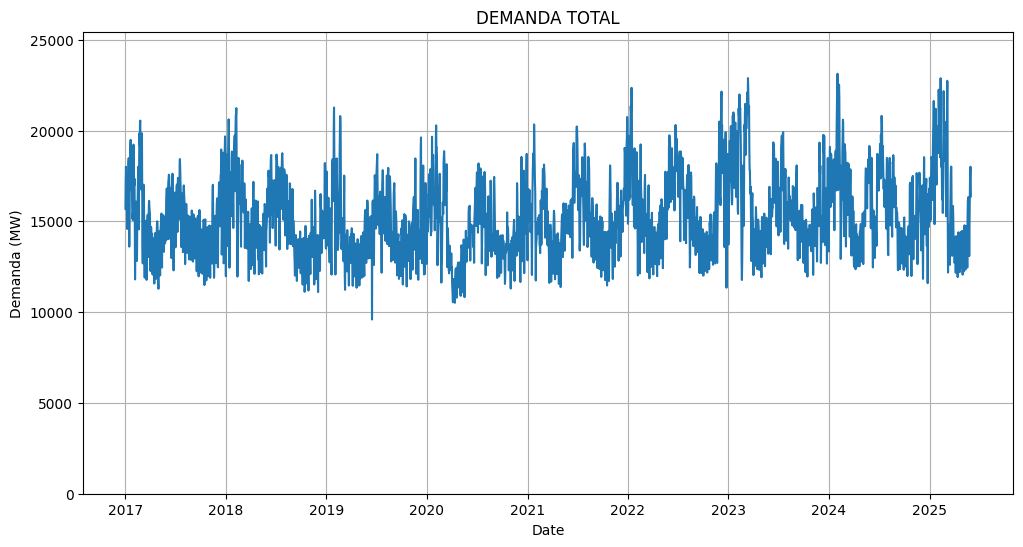

In [8]:
# Plot series
ymin = 0
# ymax = max([serie['ORIGINAL'].max() for key, serie in series.items() if key != 'DEMANDA TOTAL']) * 1.1
for col, serie in series.items():
    ymax = serie['ORIGINAL'].max() * 1.1
    plot_series(serie['ORIGINAL'], title=col, ymin=ymin, ymax=ymax)

In [9]:
# Ubicamos el pico bajo de demanda
idxmindata = series['DEMANDA TOTAL']['ORIGINAL'].idxmin().date()
print(f"Fecha del pico bajo de demanda: {idxmindata}")
# Causa: "Apagón del siglo"

Fecha del pico bajo de demanda: 2019-06-16


# Filtros de Media movil.
### Trabajamos con MA30 para obtener mejores resultados

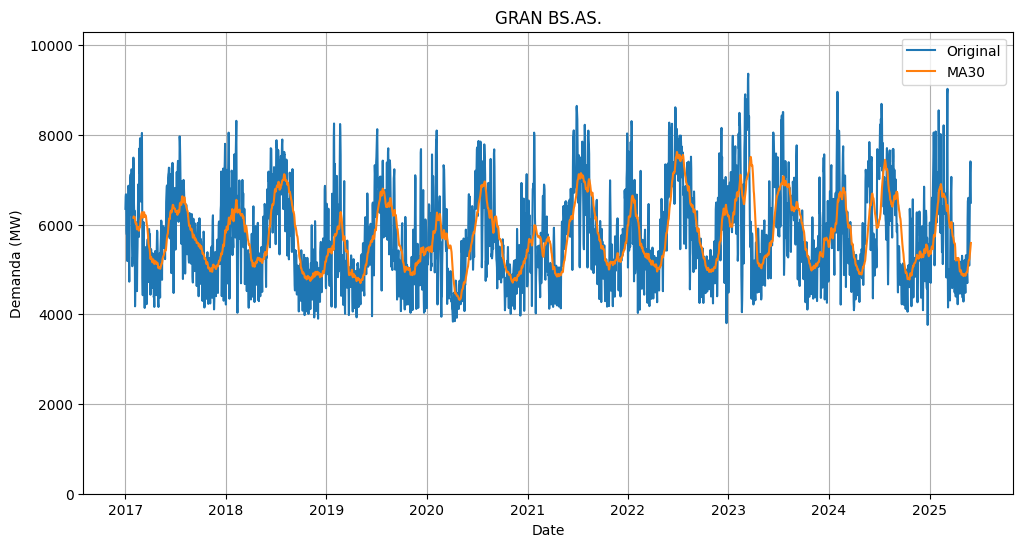

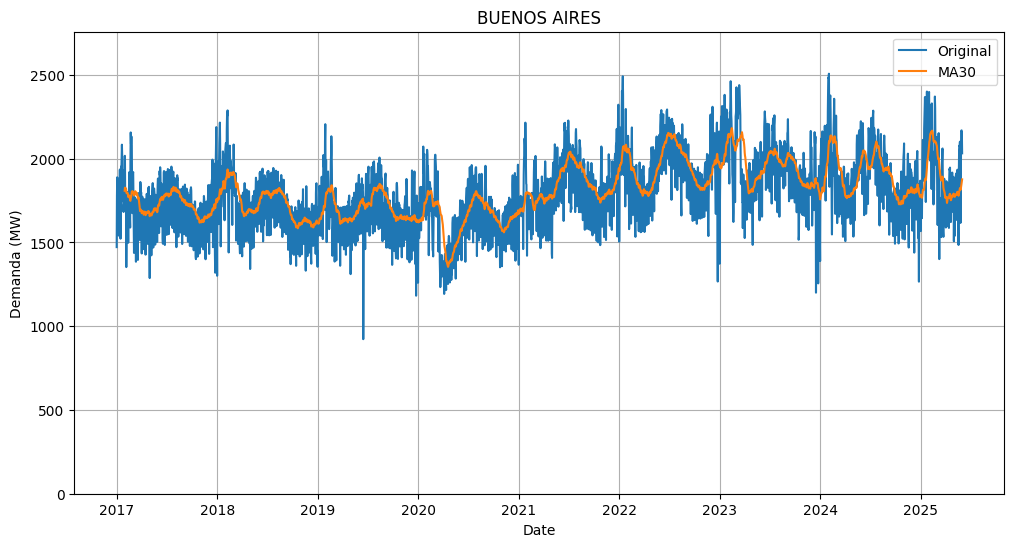

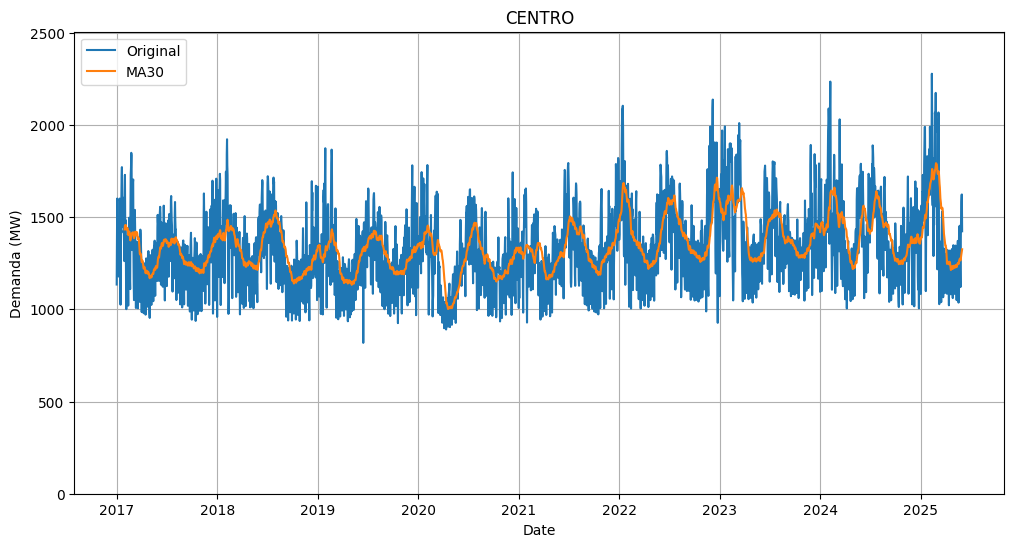

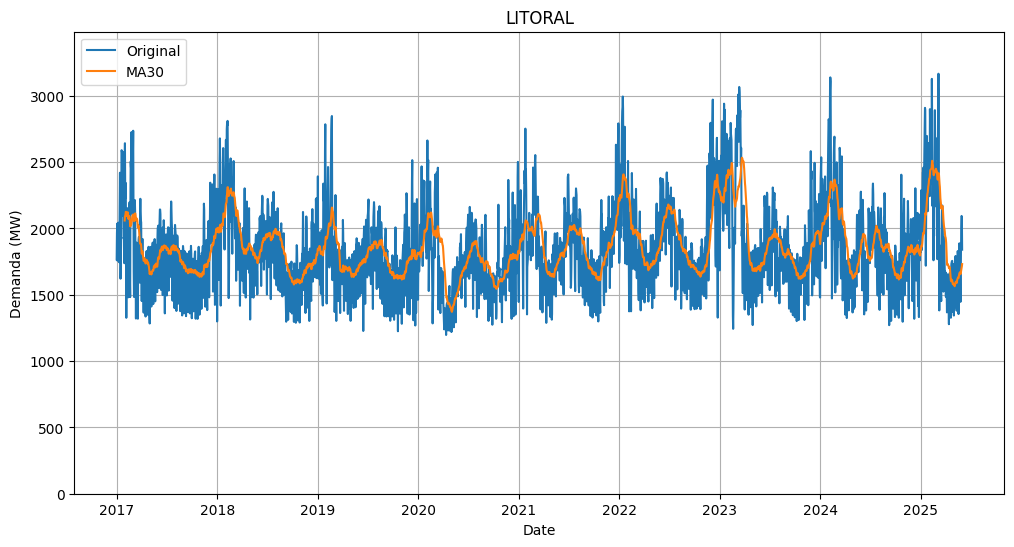

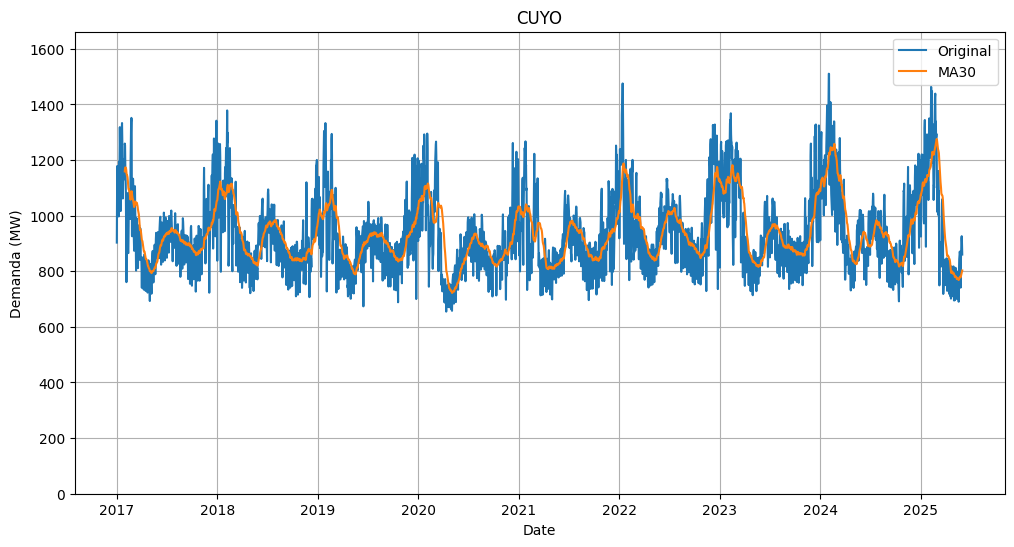

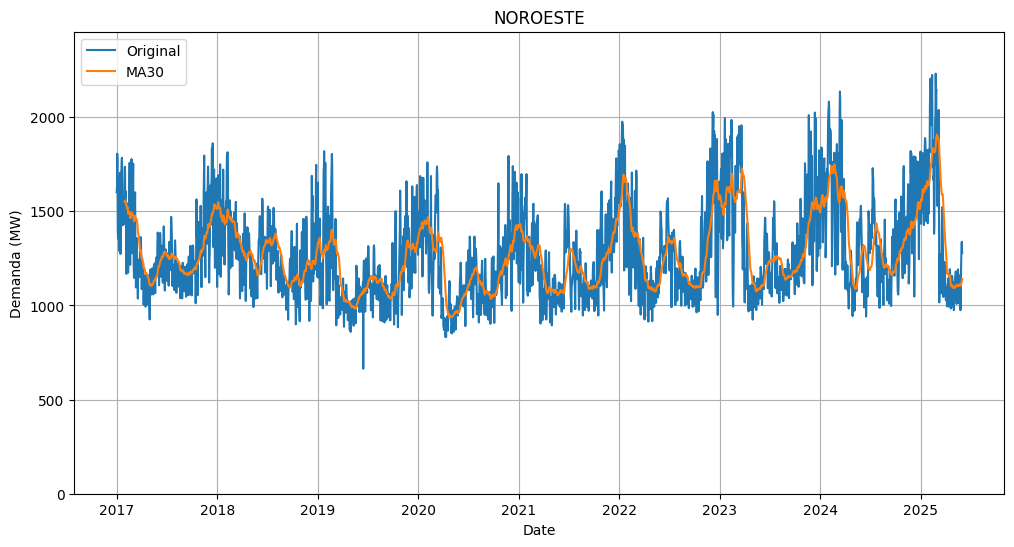

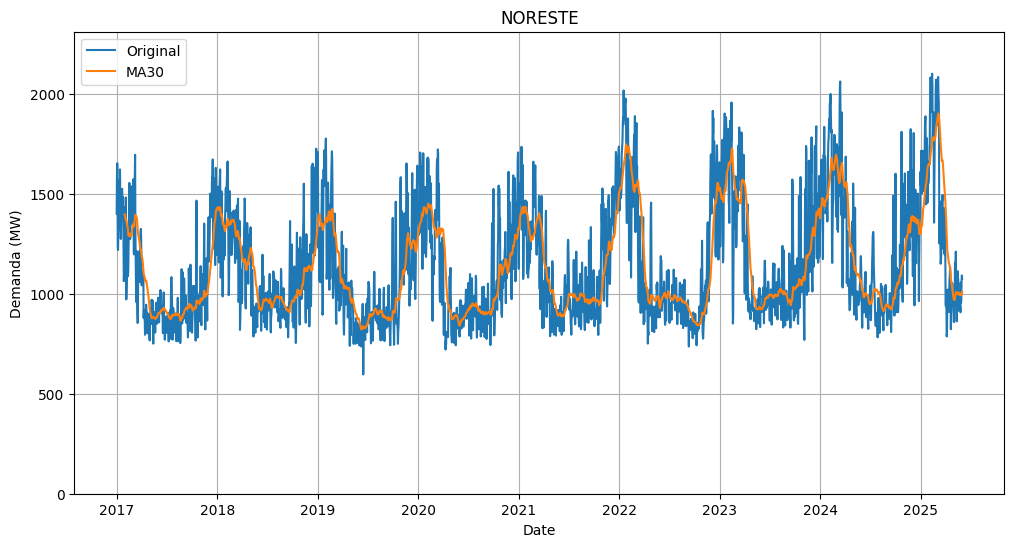

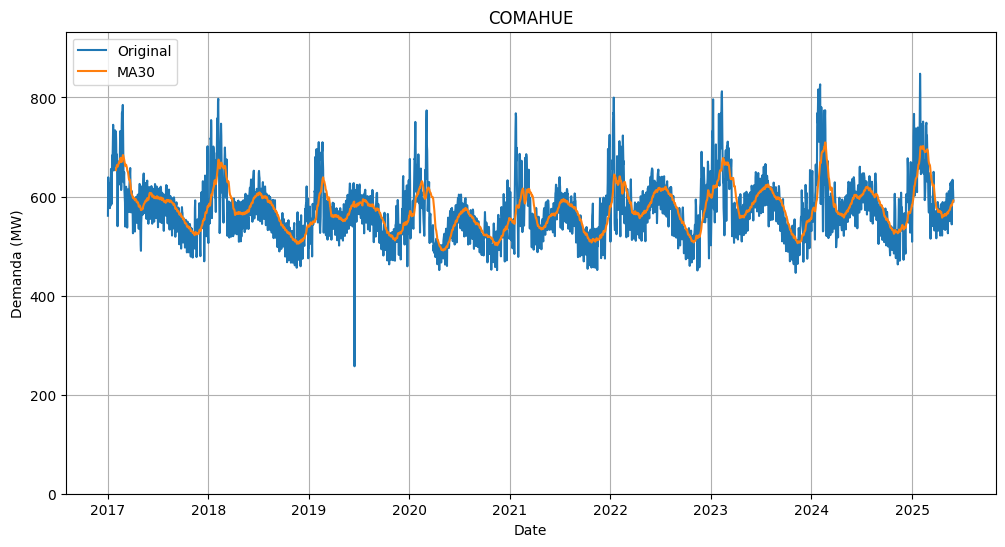

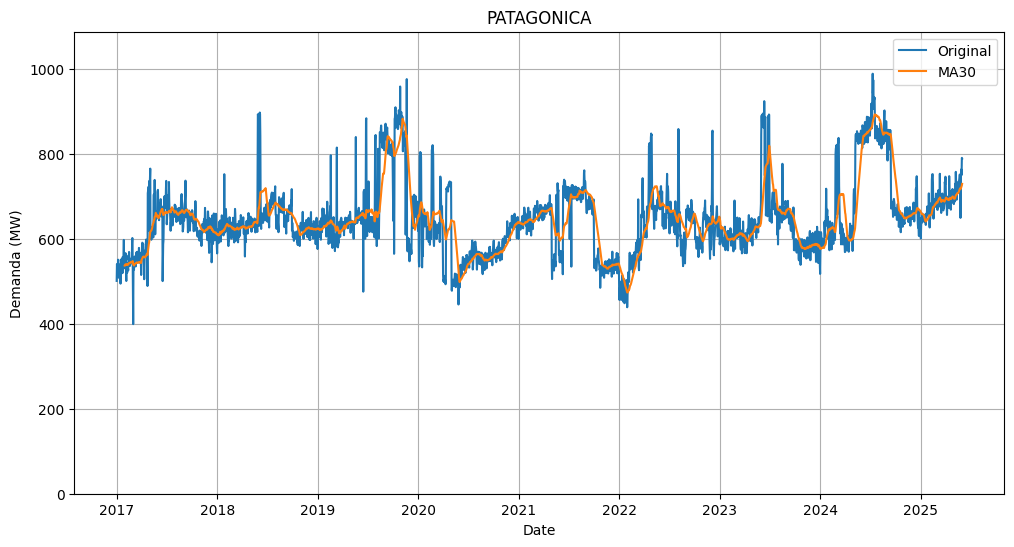

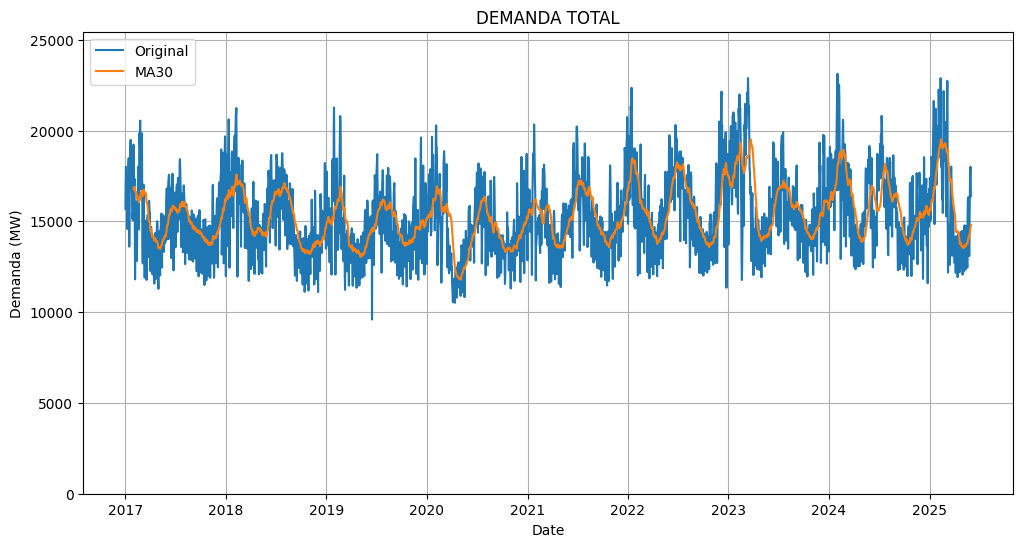

In [10]:
for col, serie in series.items():
    serie['MA30'] = moving_average(serie['ORIGINAL'], 30)
    plot_moving_average(serie['ORIGINAL'], serie['MA30'], window=30, title=col, ymin=0, ymax=serie['ORIGINAL'].max() * 1.1)

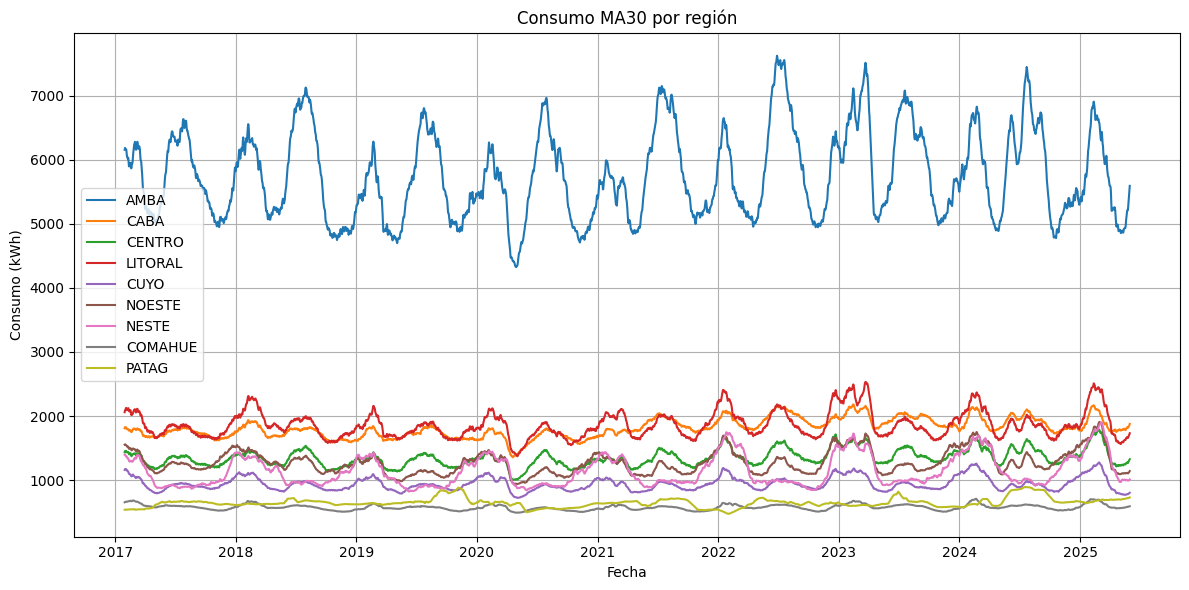

In [11]:
plt.figure(figsize=(12, 6))
for col, serie in series.items():
    if col != 'DEMANDA TOTAL': # and col != 'GRAN BS.AS.':
        plt.plot(serie['MA30'], label=serie['APODO'])
plt.title('Consumo MA30 por región')
plt.xlabel('Fecha')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('img/consumo_ma30_por_region.png', dpi=300, bbox_inches='tight')
plt.show()

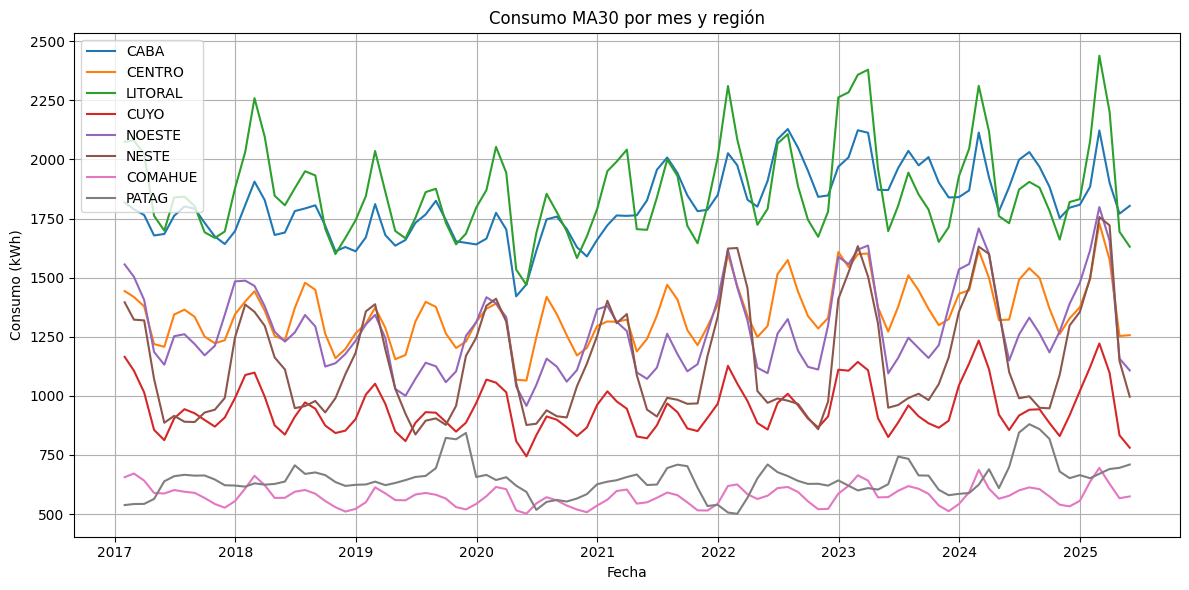

In [12]:
# Serie agrupada por mes de cada región:

for col, serie in series.items():
    serie['MES'] = serie['MA30'].resample('ME').mean()

# Heatmap de consumo por mes y región en 2023
# heatmap_data = pd.DataFrame({col: serie['MES'] for col, serie in series.items() if col != 'DEMANDA TOTAL' and col != 'GRAN BS.AS.'})
# heatmap_data = heatmap_data.loc['2020-01-01':'2021-12-31']
# heatmap_data = heatmap_data.T
# heatmap_data.index.name = 'Región'
# heatmap_data.columns.name = 'Mes'
# plt.figure(figsize=(12, 6))
# plt.imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Consumo (kWh)')
# plt.xticks(ticks=range(len(heatmap_data.columns)), labels=heatmap_data.columns.strftime('%b'), rotation=45)
# plt.yticks(ticks=range(len(heatmap_data.index)), labels=heatmap_data.index)
# plt.title('Consumo por mes y región en 2023')
# plt.xlabel('Mes')
# plt.ylabel('Región')
# plt.tight_layout()
# plt.show()

# grafico en funcion del mes de cada región
plt.figure(figsize=(12, 6))
for col, serie in series.items():
    if col != 'DEMANDA TOTAL' and col != 'GRAN BS.AS.':
        plt.plot(serie['MES'], label=serie['APODO'])
plt.title('Consumo MA30 por mes y región')
plt.xlabel('Fecha')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('img/consumo_ma30_mes.png', dpi=300, bbox_inches='tight')
plt.show()

# Test de estacionalidad
### Utilizamos ADF y KPSS

In [13]:
for col, serie in series.items():
    serie['SEASONALITY'] = seasonality_tests(serie['ORIGINAL'])
    print_stationarity_tests(results=serie['SEASONALITY'], name=serie['APODO'])
    print('-----------------------------------------------------------')

[ADF](0.00)		AMBA		Es estacionaria
[KPSS](0.10)		AMBA		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CABA		Es estacionaria
[KPSS](0.01)		CABA		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CENTRO		Es estacionaria
[KPSS](0.01)		CENTRO		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		LITORAL		Es estacionaria
[KPSS](0.04)		LITORAL		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CUYO		Es estacionaria
[KPSS](0.10)		CUYO		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		NOESTE		Es estacionaria
[KPSS](0.01)		NOESTE		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		NESTE		Es estacionaria
[KPSS](0.02)		NESTE		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		COMAHUE		Es estacionaria
[KPSS](0.06)		

# Parcialmente estacionaria
### Podemos aplicarle diferenciación

In [14]:
for col, serie in series.items():
    serie['DIFF'] = differentiate(serie['ORIGINAL'])
    serie['DIFF_SEASONALITY'] = seasonality_tests(serie['DIFF'])
    print_stationarity_tests(results=serie['DIFF_SEASONALITY'], name=serie['APODO'])
    print('-----------------------------------------------------------')

[ADF](0.00)		AMBA		Es estacionaria
[KPSS](0.10)		AMBA		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CABA		Es estacionaria
[KPSS](0.10)		CABA		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CENTRO		Es estacionaria
[KPSS](0.10)		CENTRO		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		LITORAL		Es estacionaria
[KPSS](0.10)		LITORAL		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CUYO		Es estacionaria
[KPSS](0.10)		CUYO		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		NOESTE		Es estacionaria
[KPSS](0.10)		NOESTE		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		NESTE		Es estacionaria
[KPSS](0.10)		NESTE		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		COMAHUE		Es estacionaria
[KPSS](0.10)		COMAHUE		Es est

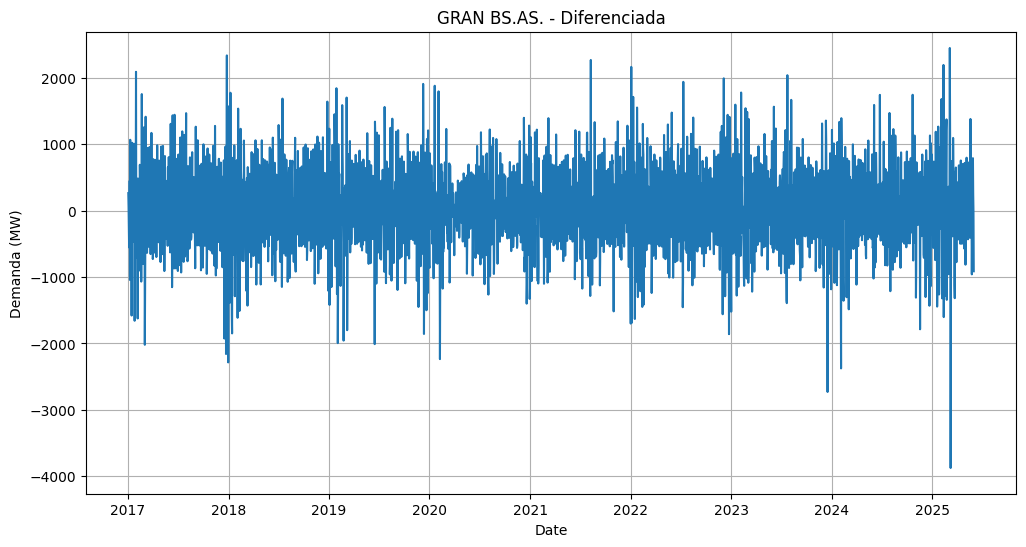

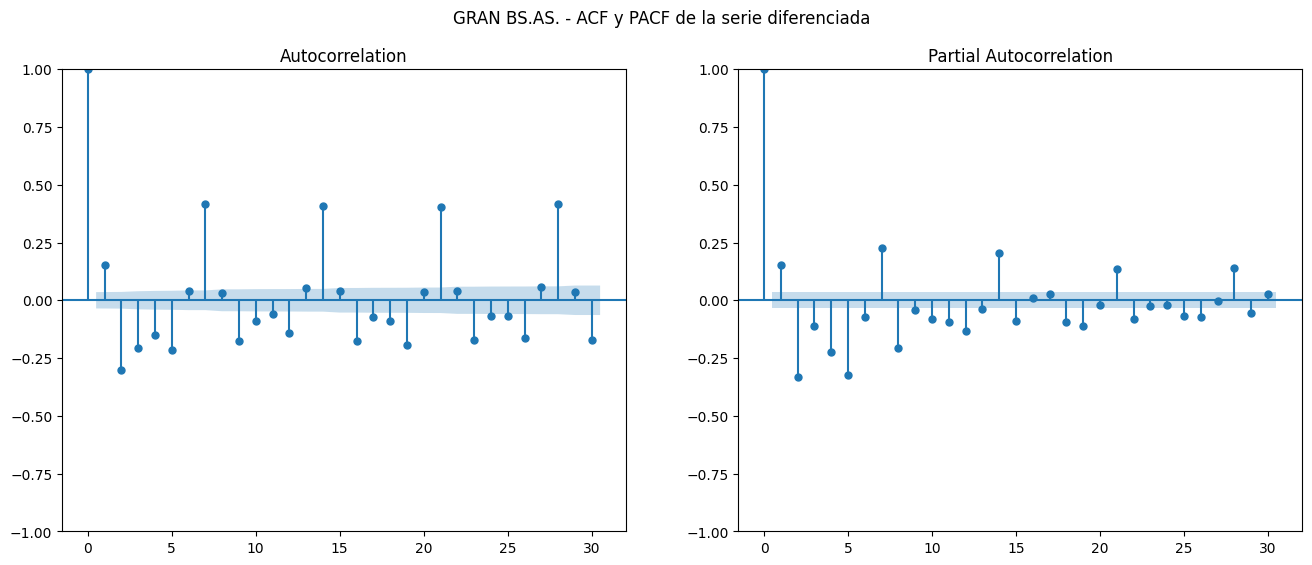

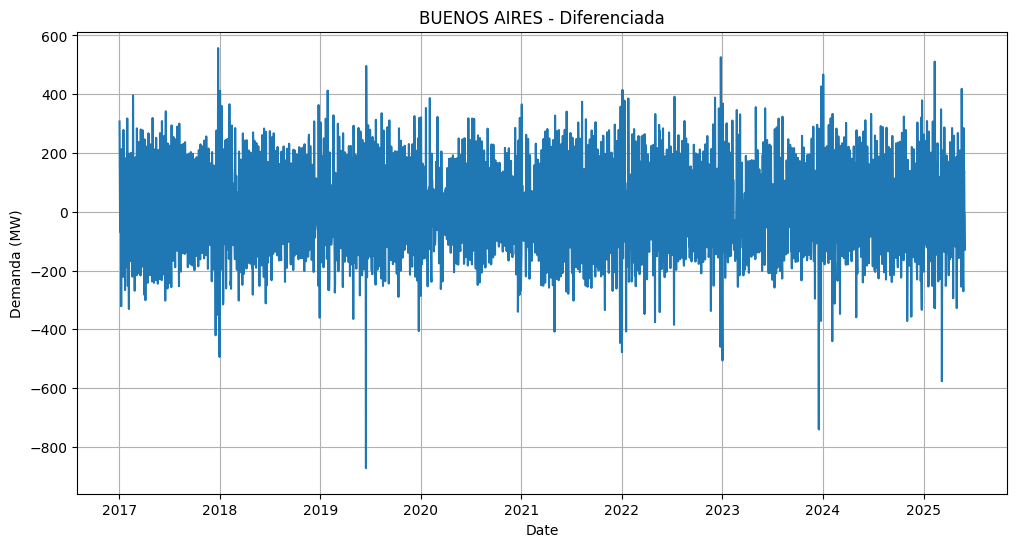

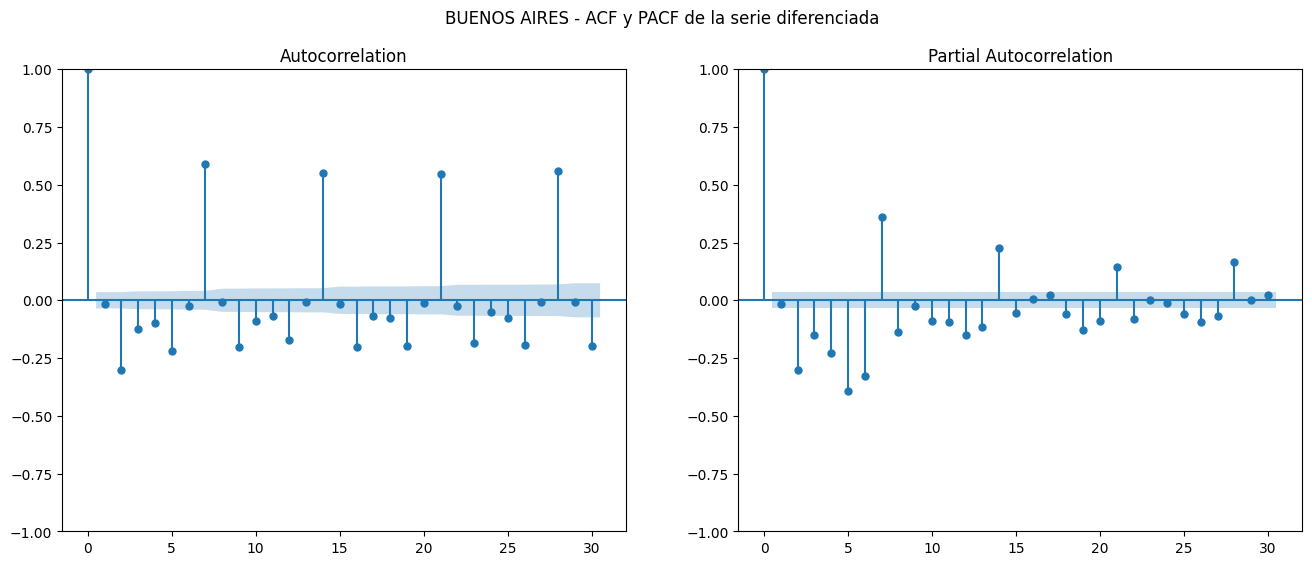

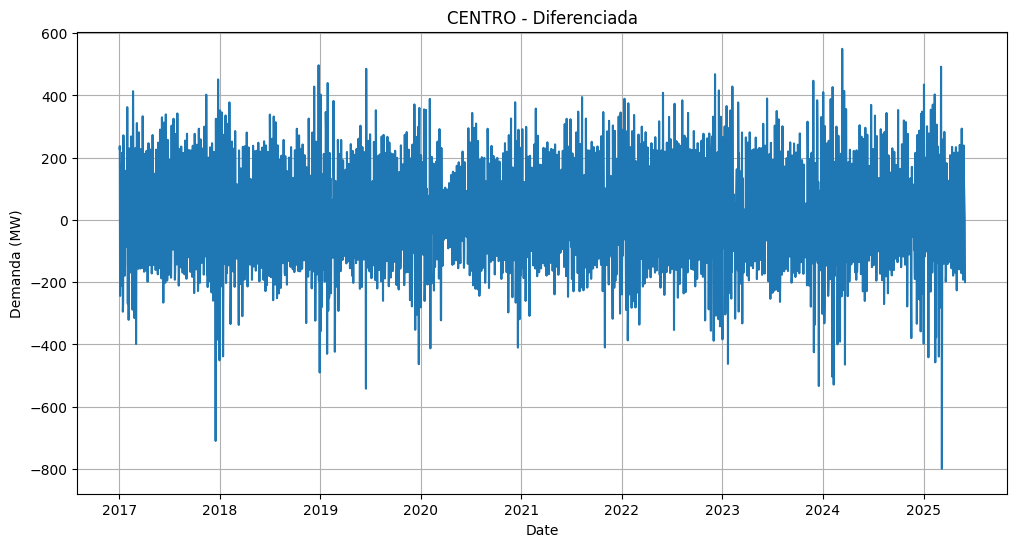

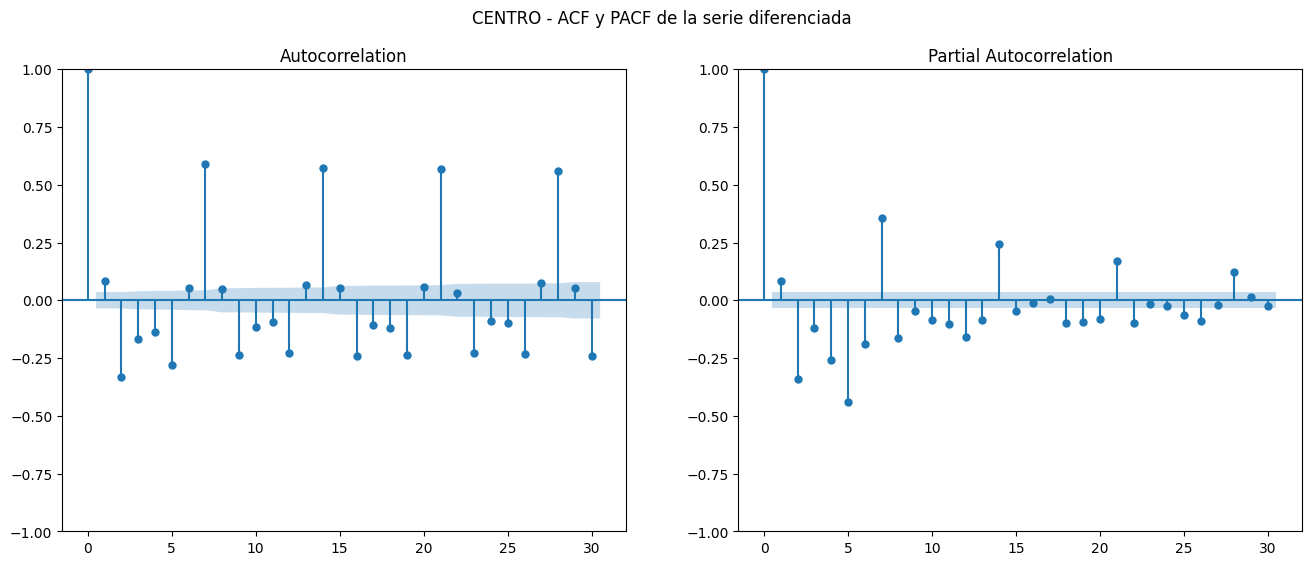

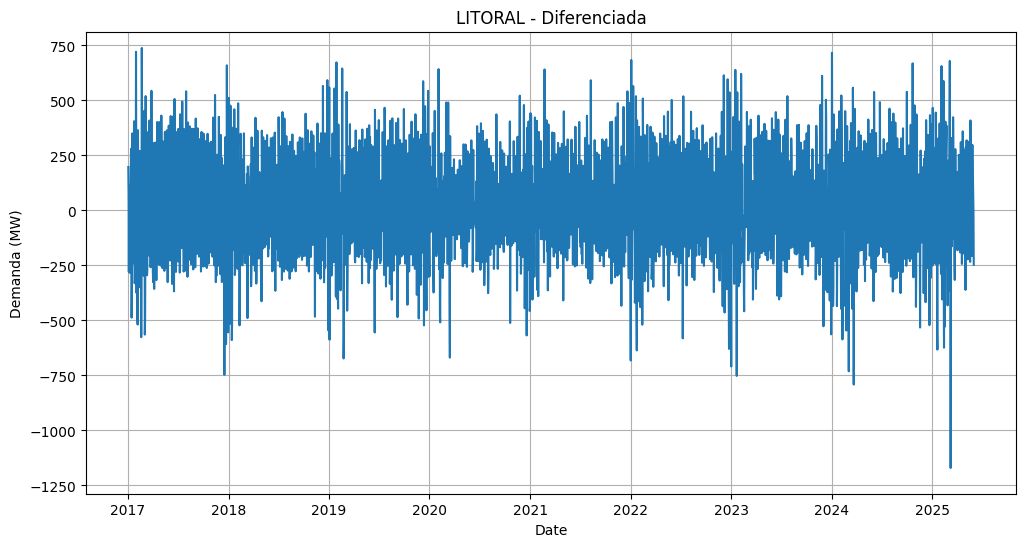

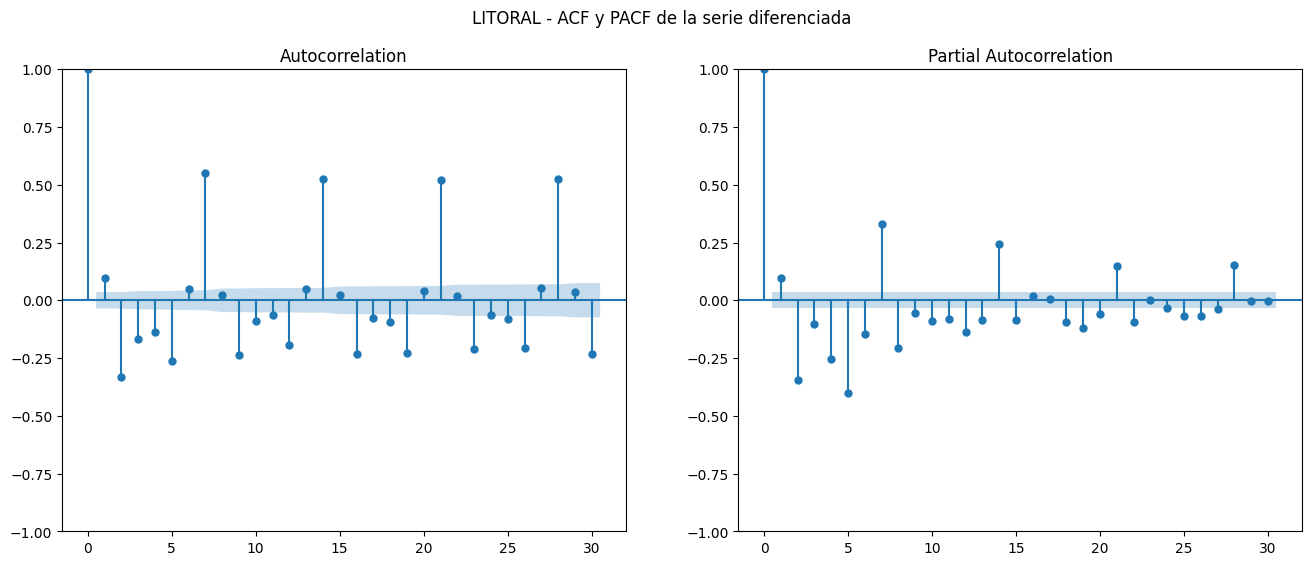

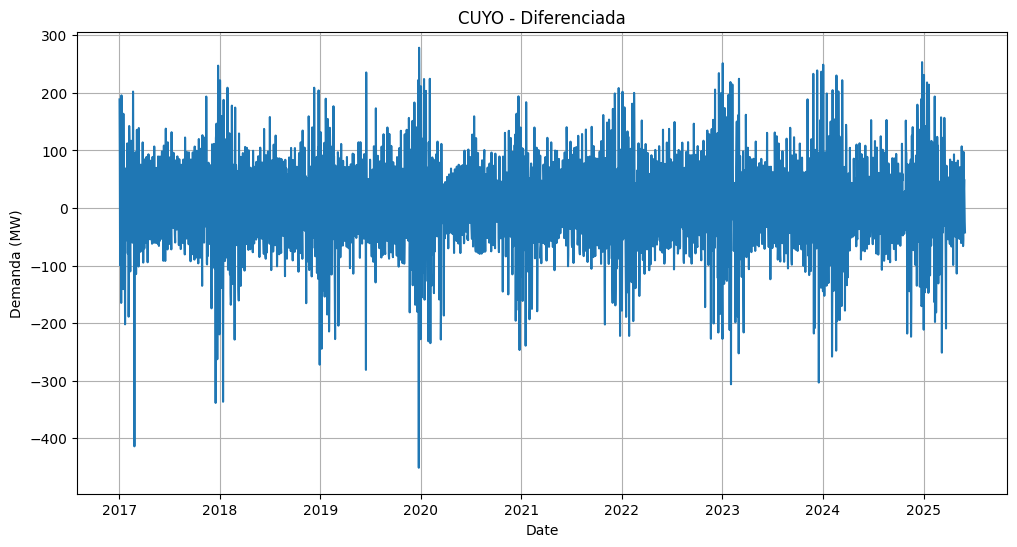

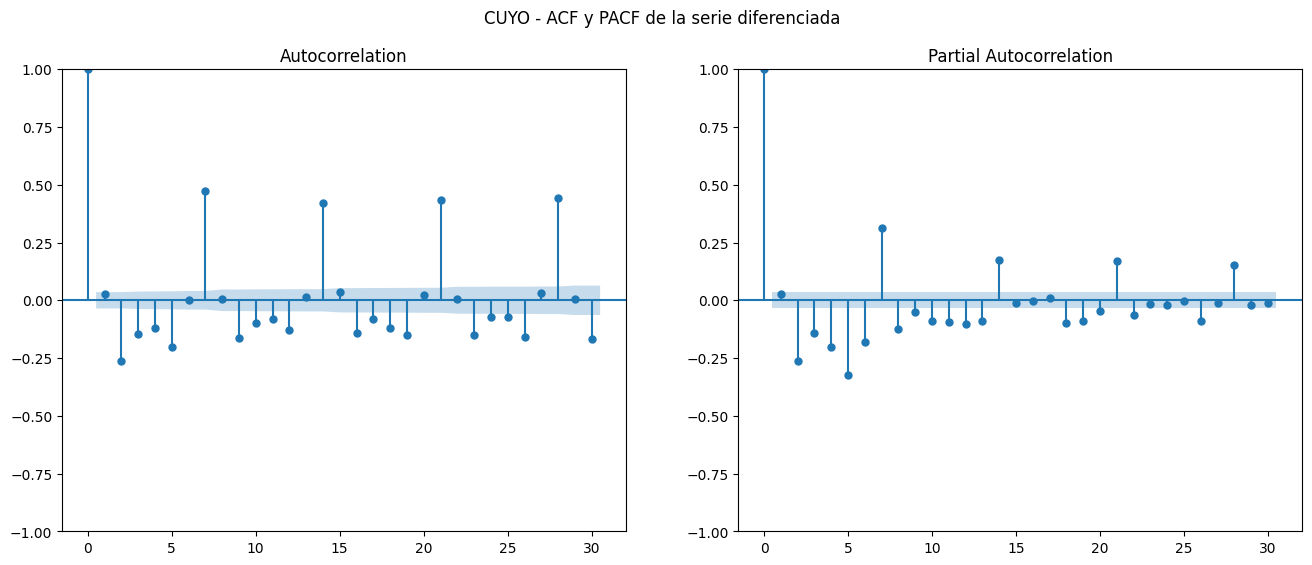

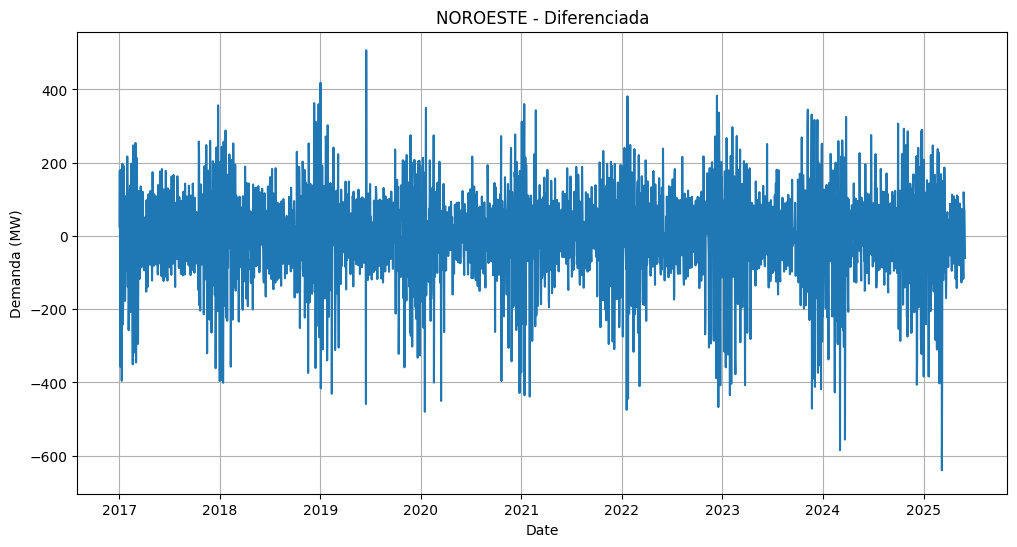

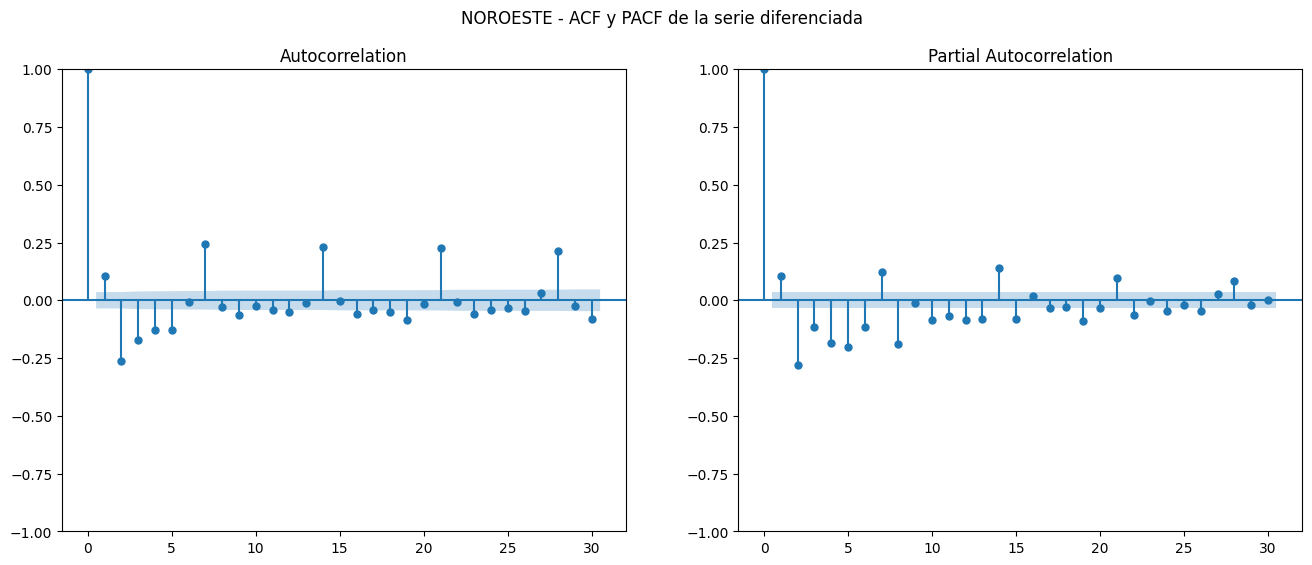

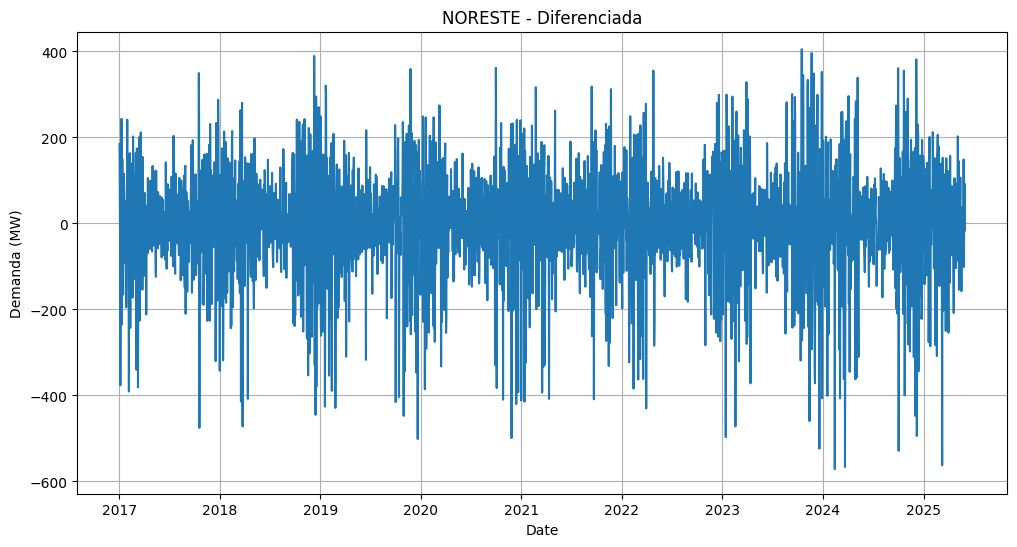

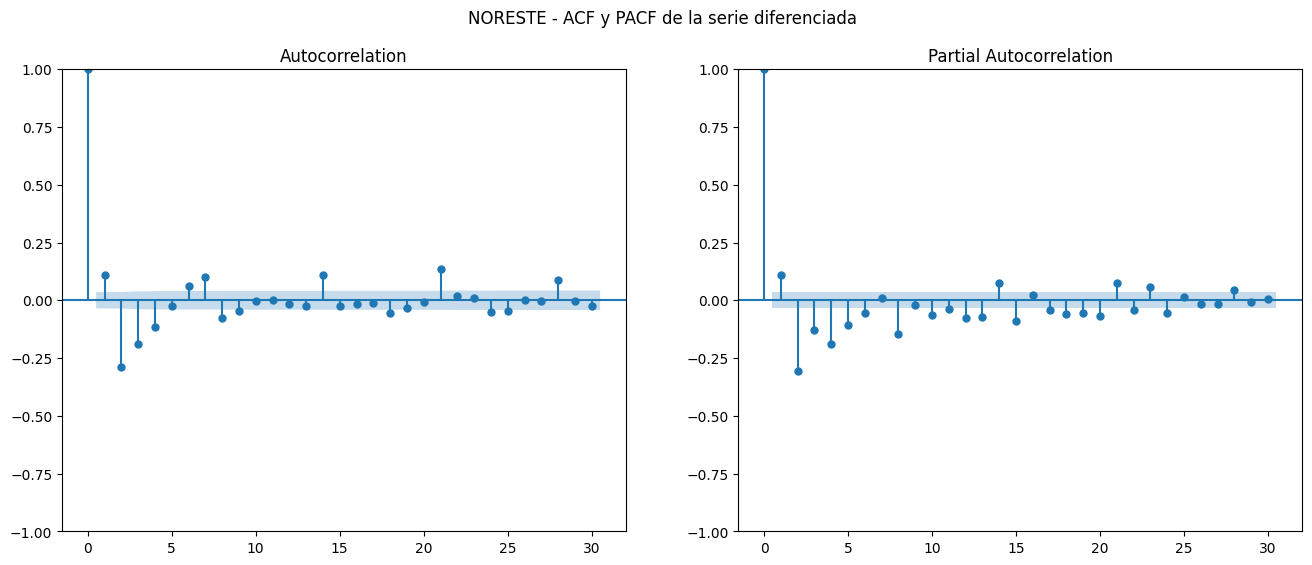

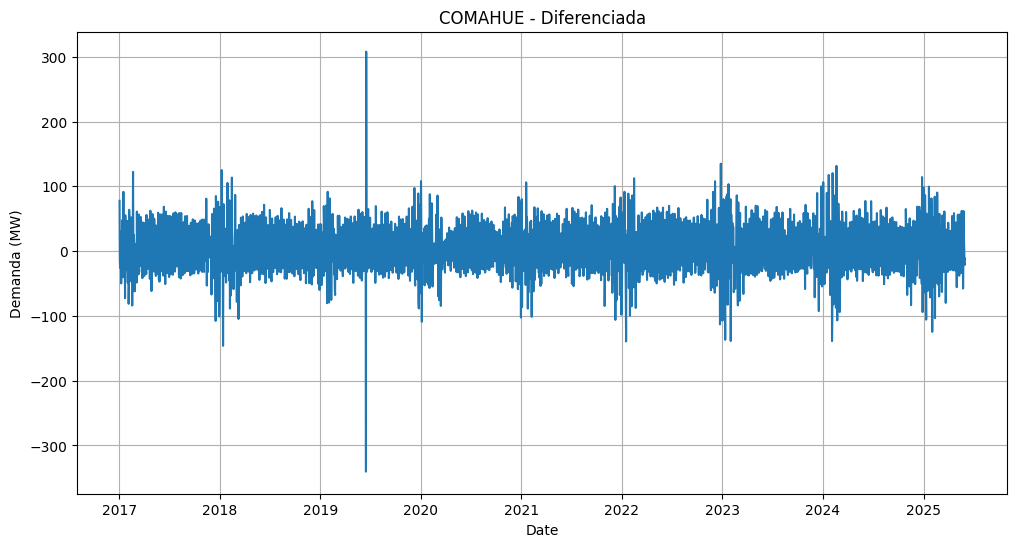

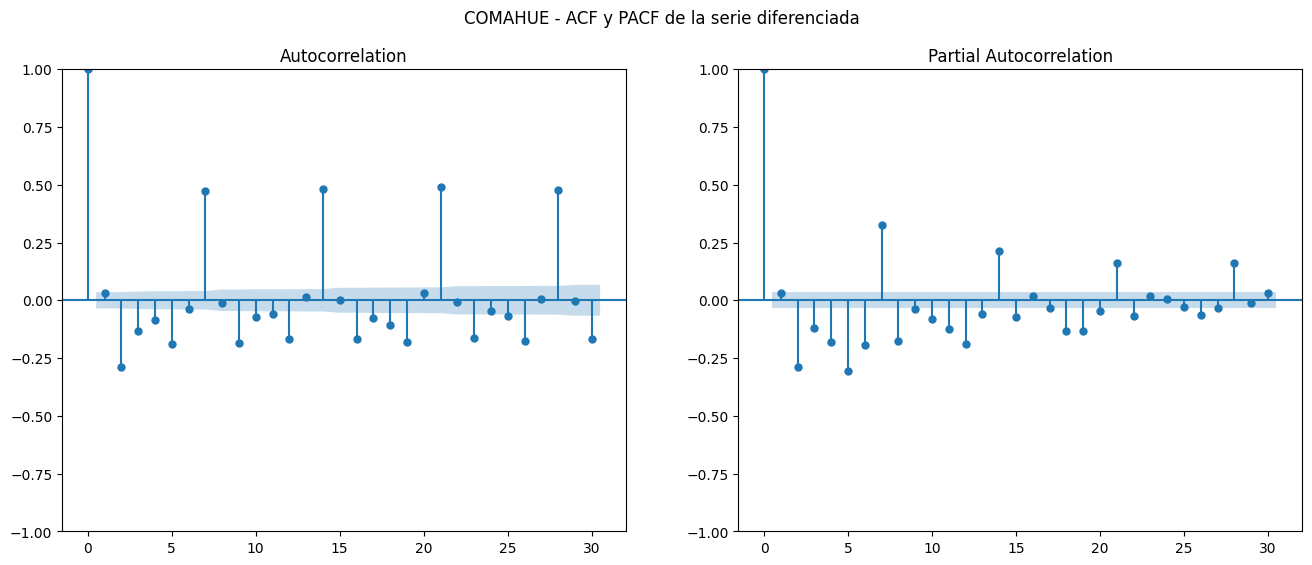

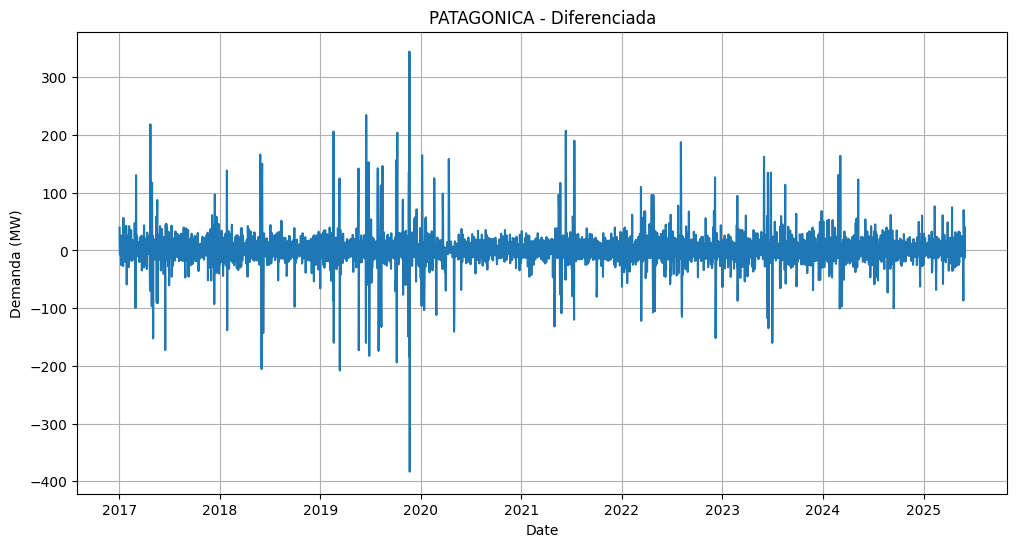

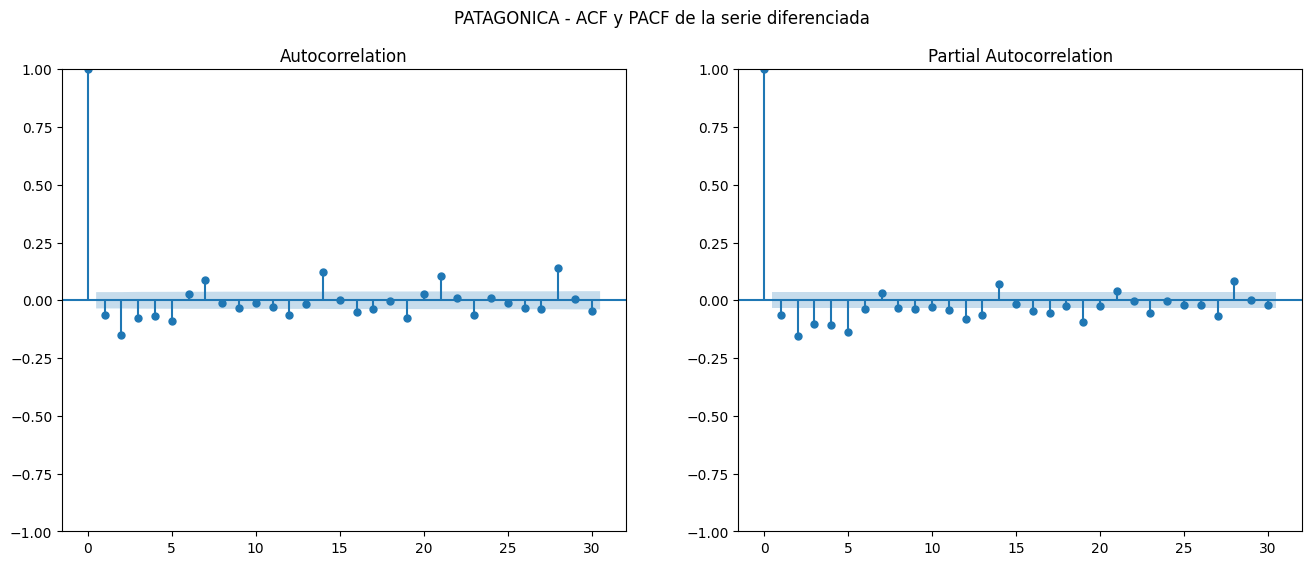

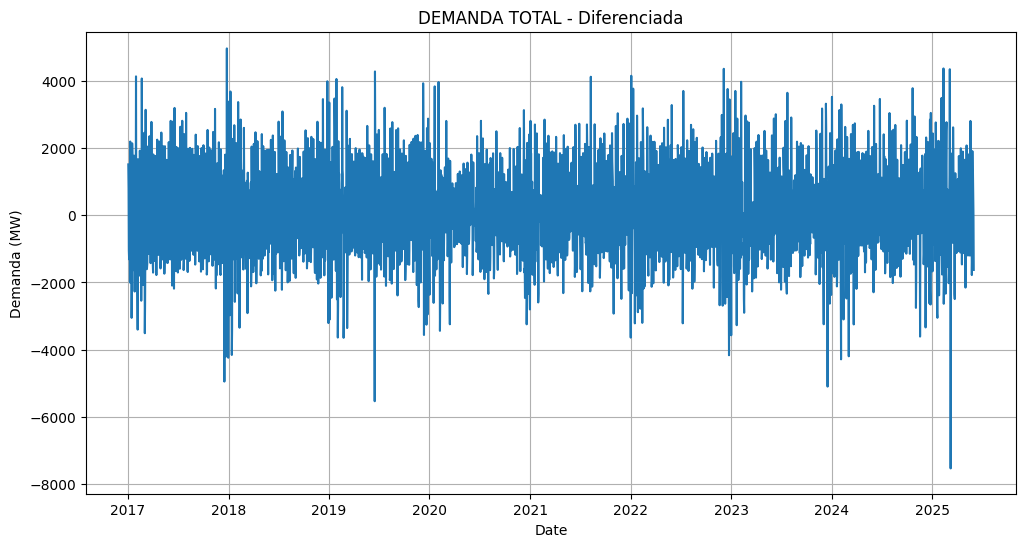

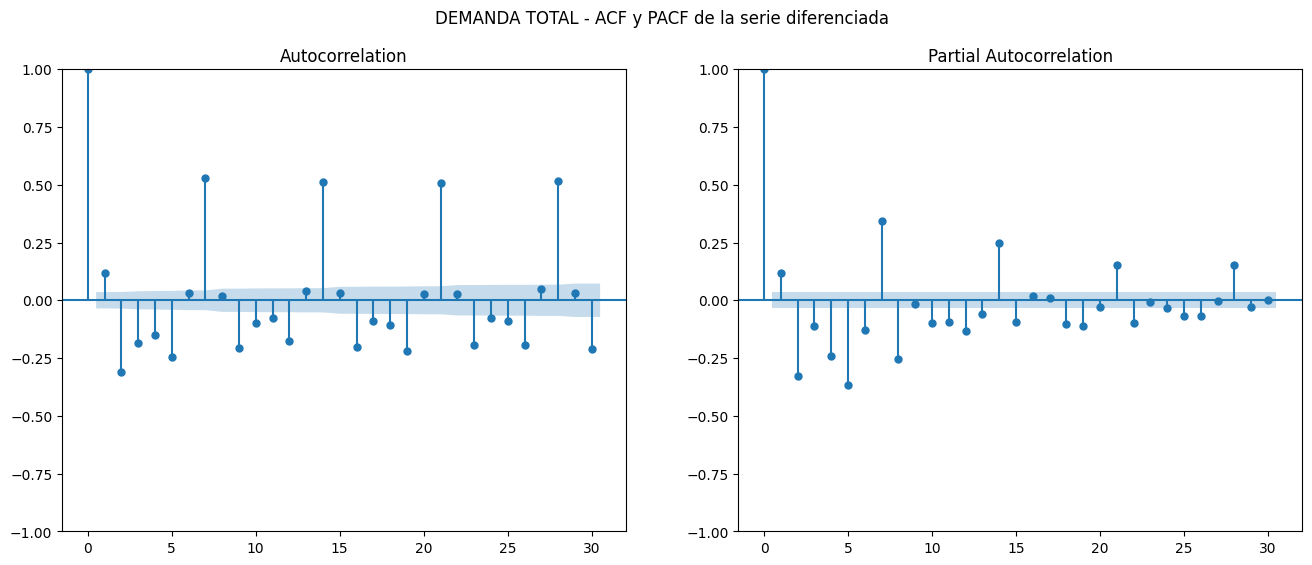

In [15]:
for col, serie in series.items():
    plot_series(serie['DIFF'], title=f"{col} - Diferenciada", ymin=serie['DIFF'].min() * 1.1, ymax=serie['DIFF'].max() * 1.1)
    # plot_acf_pacf(serie['ORIGINAL'], lags=30, title=f"{col} - ACF y PACF de la serie original")
    plot_acf_pacf(serie['DIFF'], lags=30, title=f"{col} - ACF y PACF de la serie diferenciada")

# Separamos datos de entrenamiento
### 70-30 como el fernet

In [16]:
# for col, serie in series.items():
#     serie['TRAIN'], serie['TEST'] = train_test_split(serie['ORIGINAL'], test_size=0.3)
#     serie['FITTED'] = fit_arima(serie['TRAIN'], order=(6, 1, 1))
#     serie['FITTED'] = fit_sarima(serie['TRAIN'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
#     serie['FORECAST_SARIMA'], serie['CONF_INT_SARIMA'] = forecast_arima(serie['FITTED'], start=serie['TEST'].index[0], steps=len(serie['TEST']), periods=len(serie['TEST']))
#     plot_arima_forecast(serie['TRAIN'], 
#                         serie['TEST'], 
#                         serie['FORECAST_SARIMA'], 
#                         serie['CONF_INT_SARIMA'], 
#                         title=f"{col} - ARIMA")

# (S)ARIMA nos anda mal...
### TODO: Evaluar los parámetros, preguntarle a Risk

# Descomposición Tendencia + Estacionalidad + Residuo

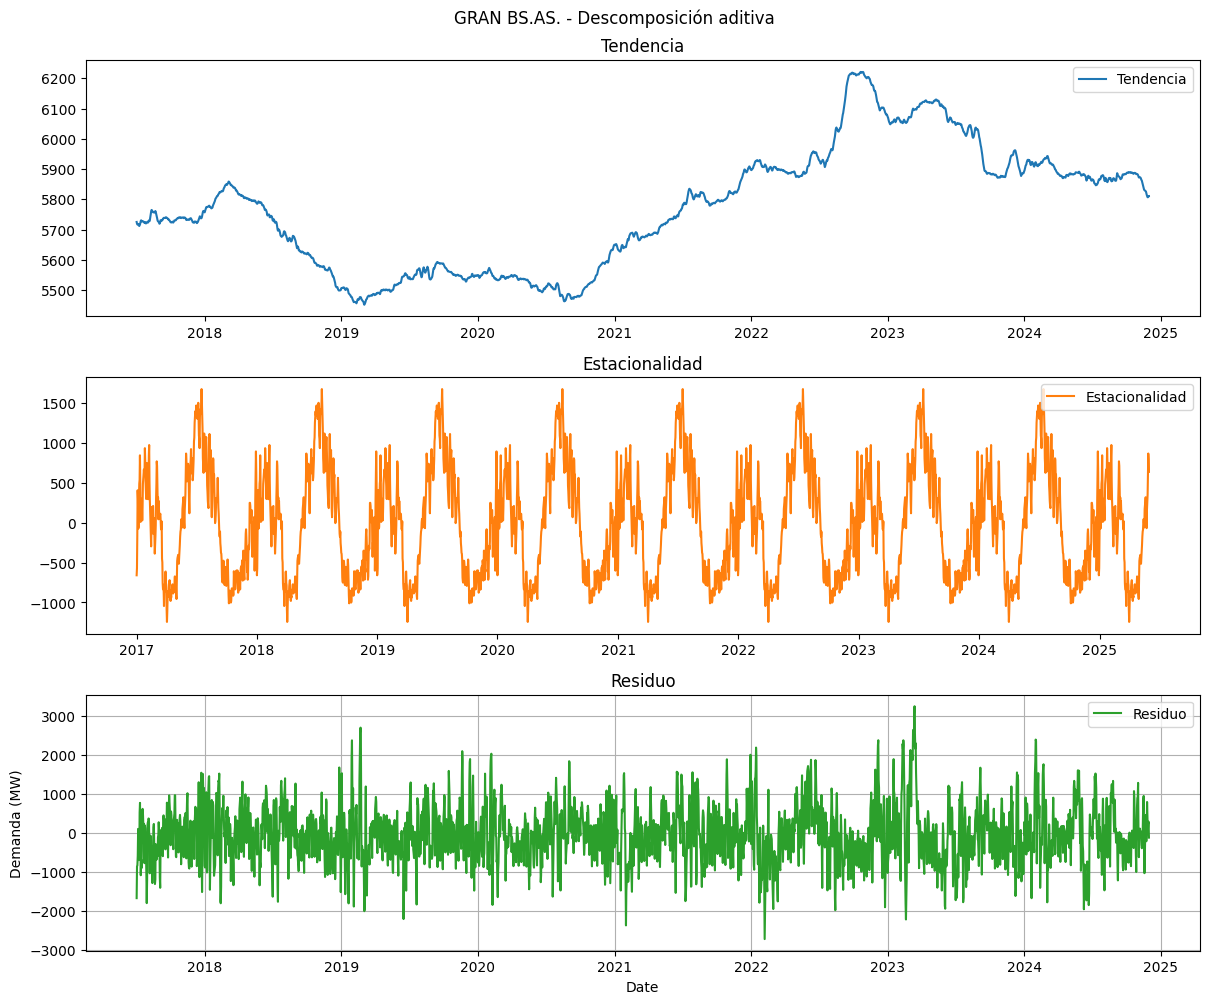

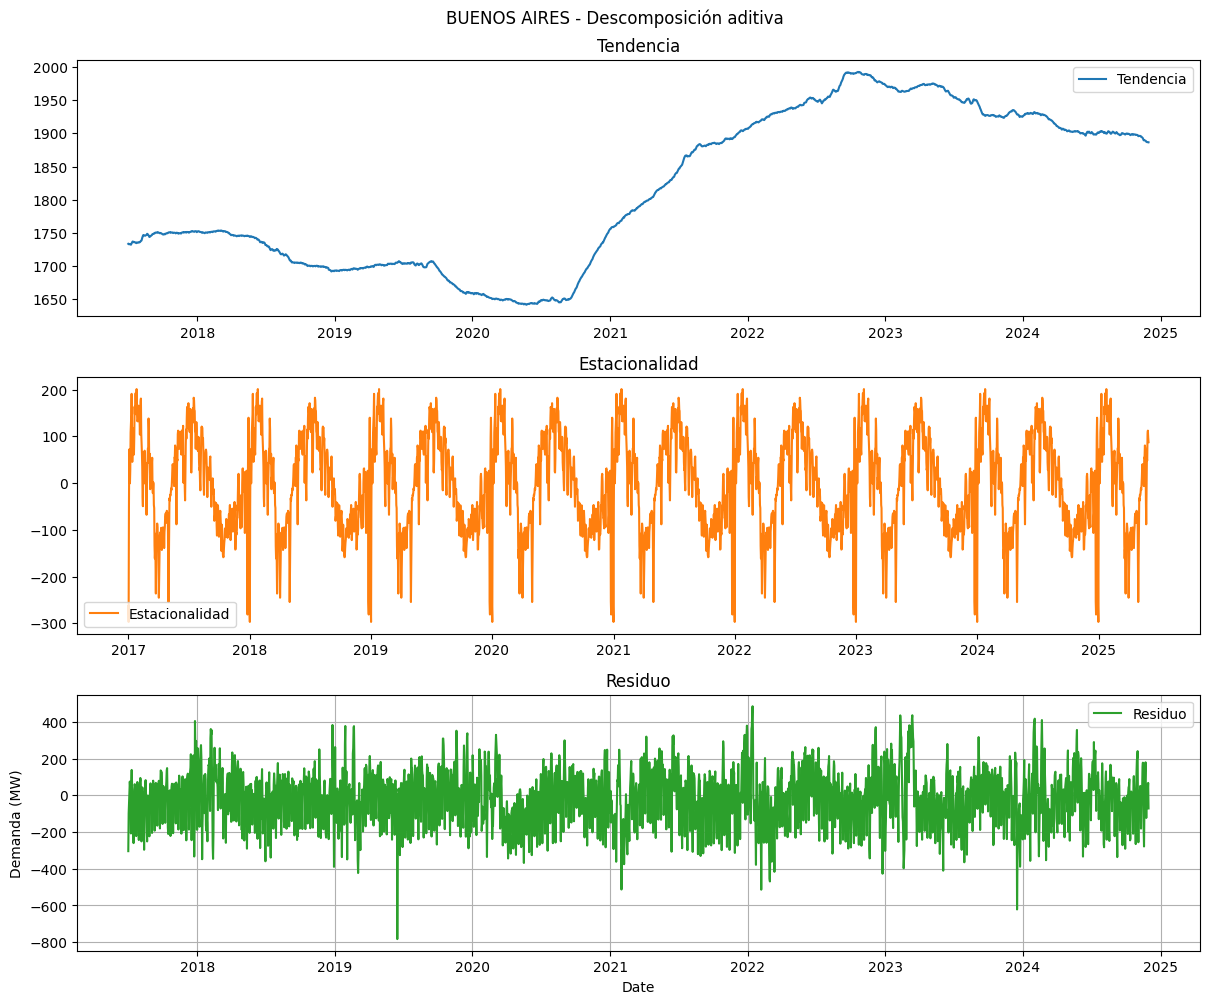

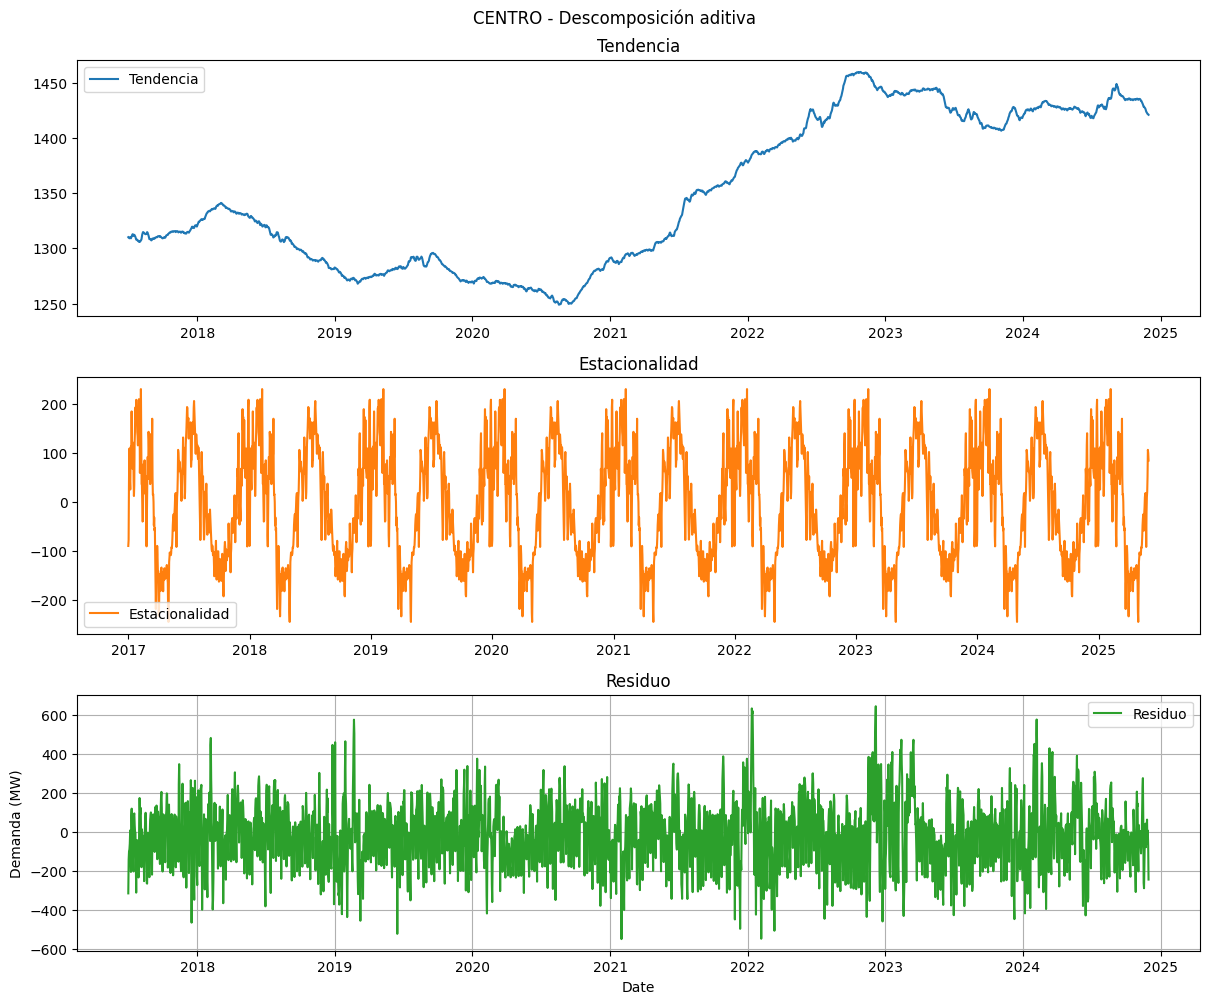

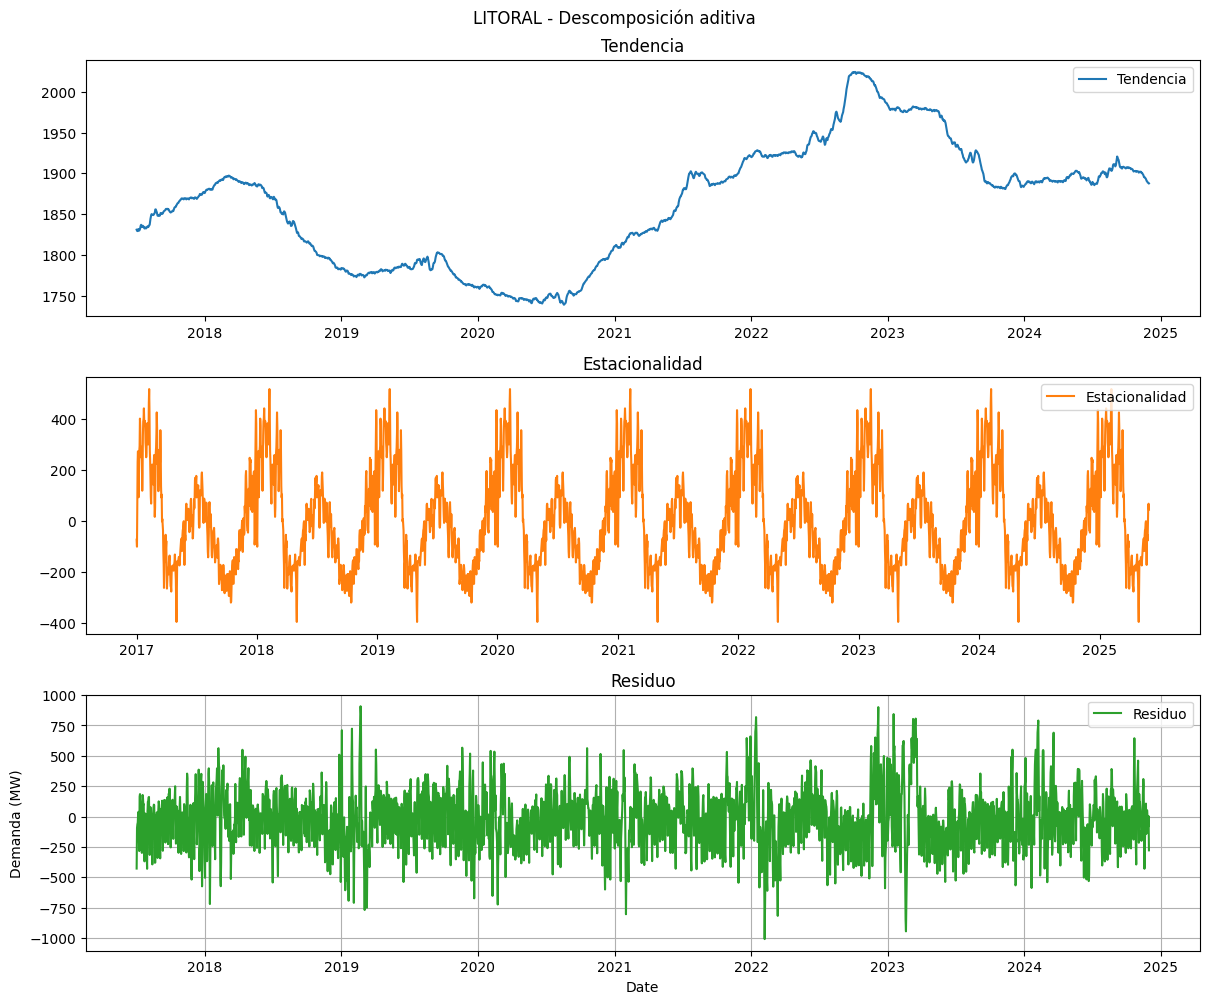

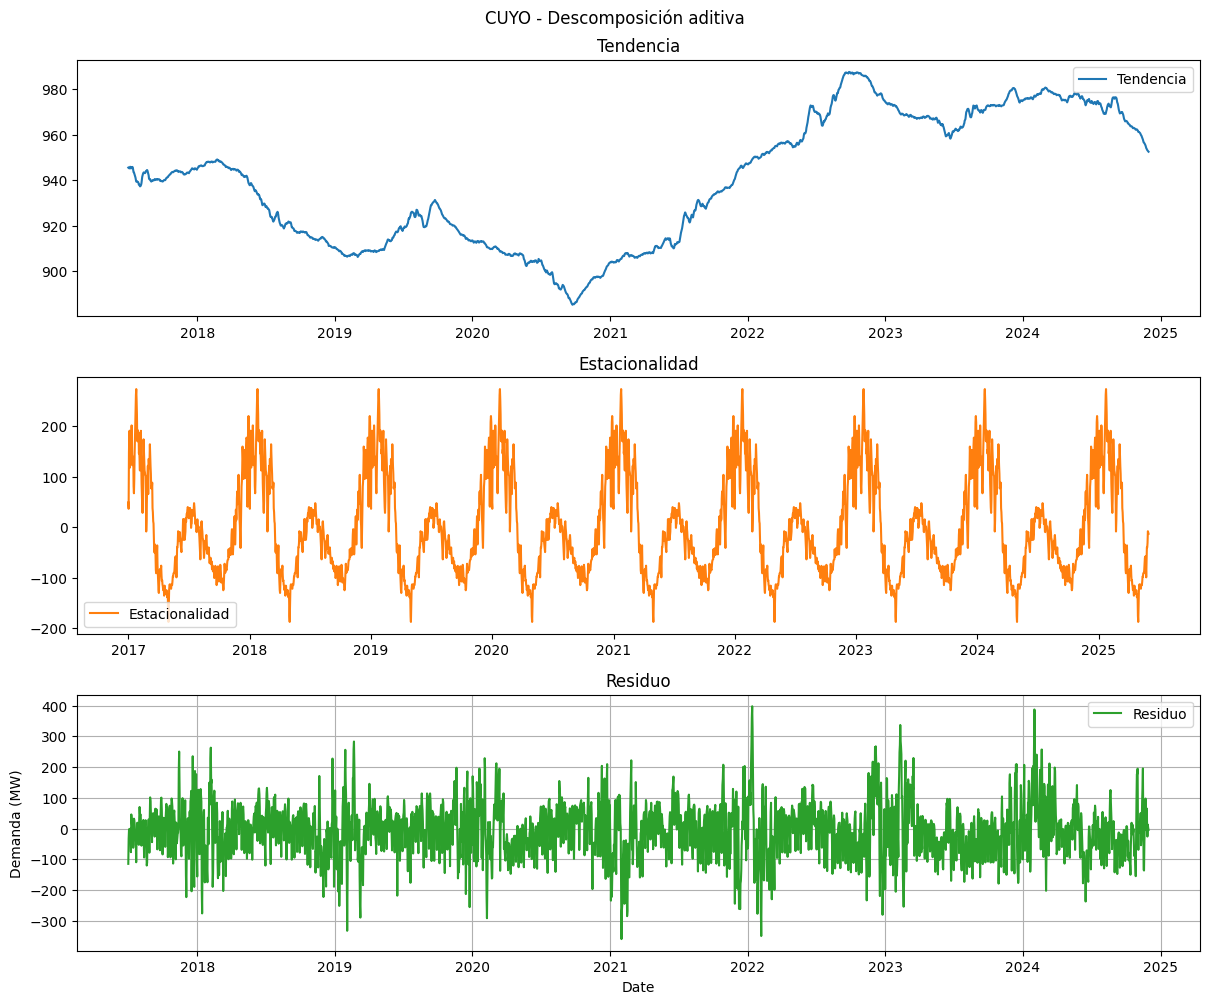

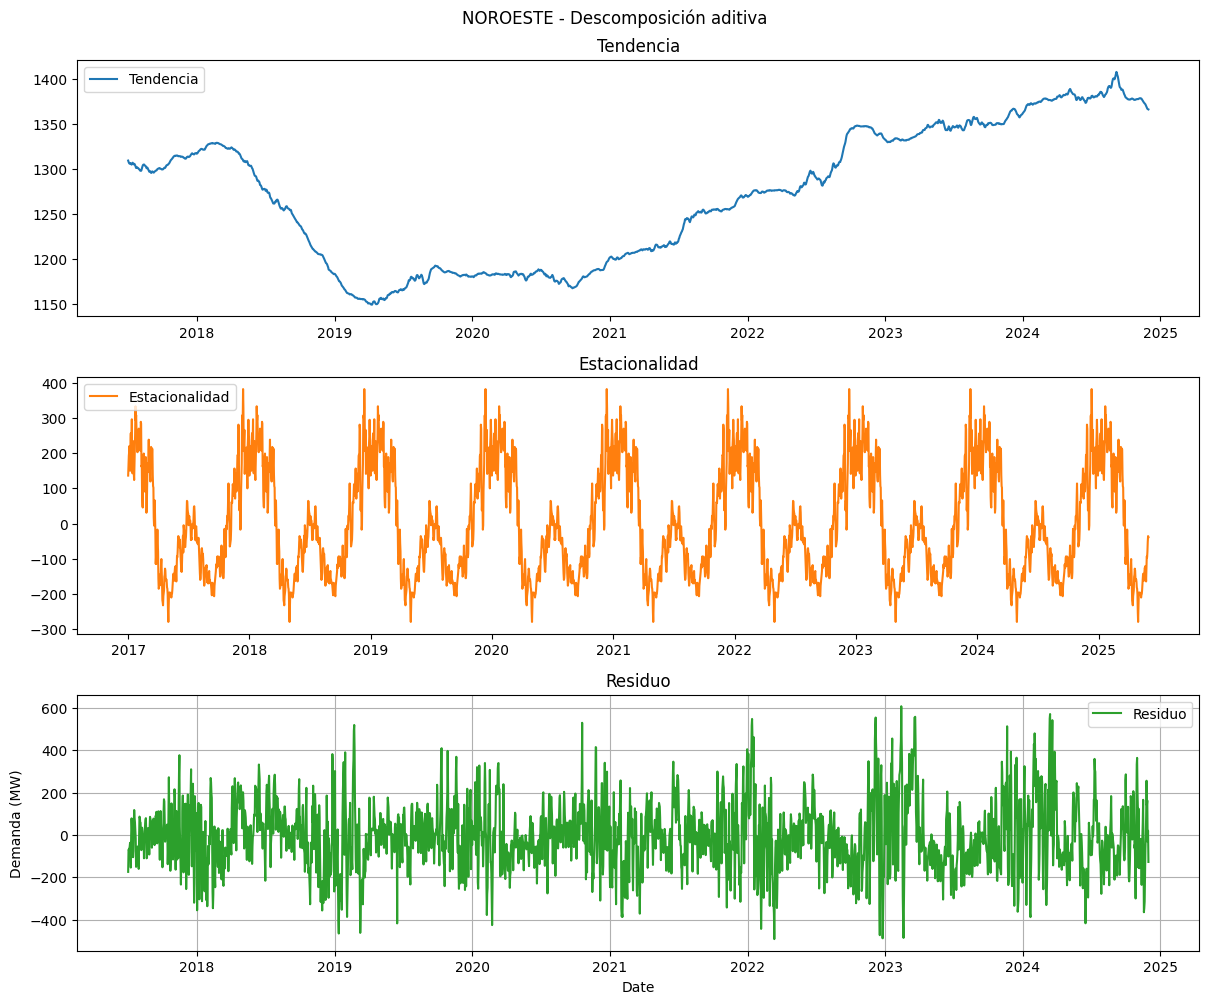

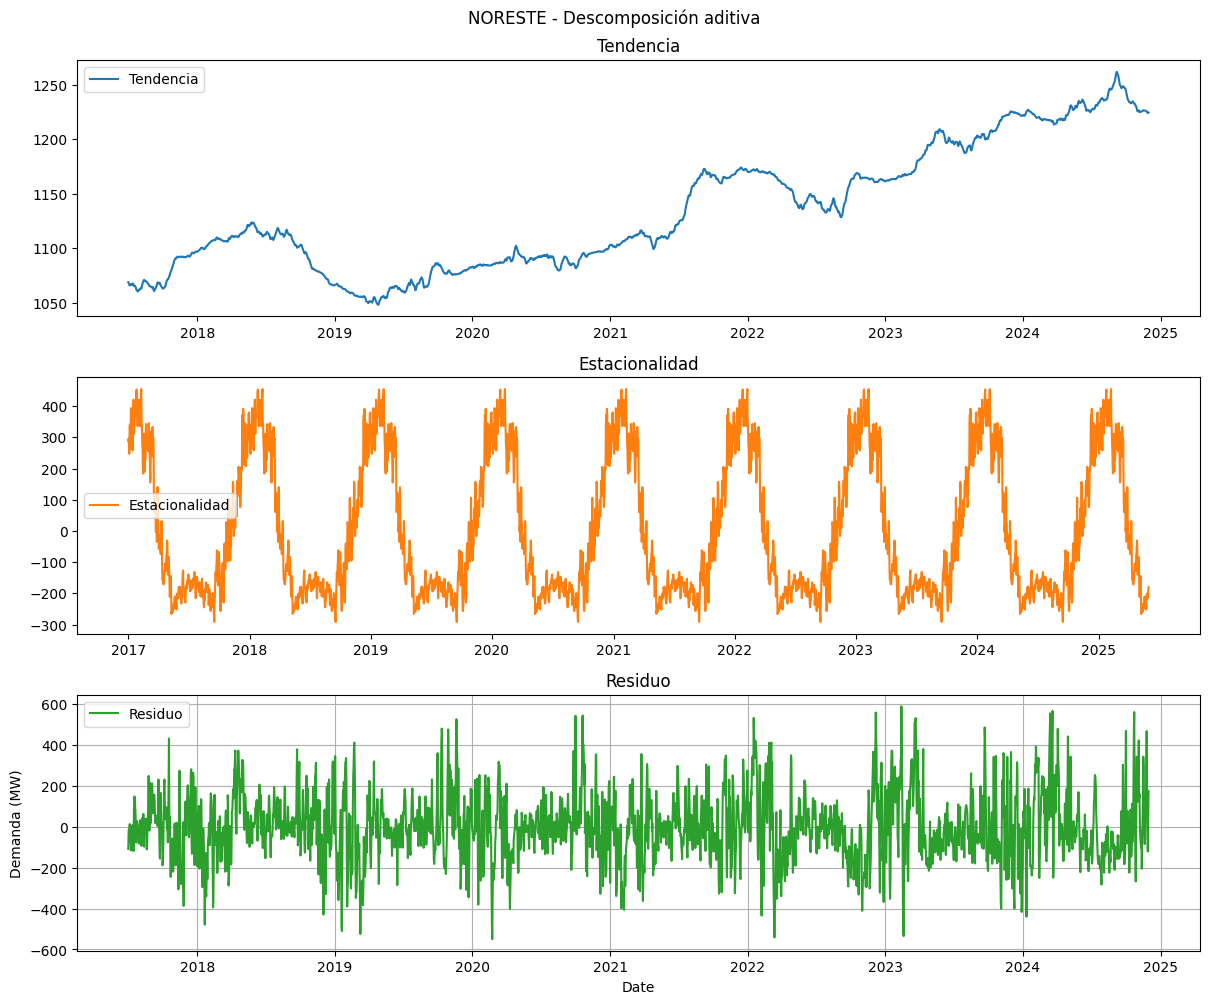

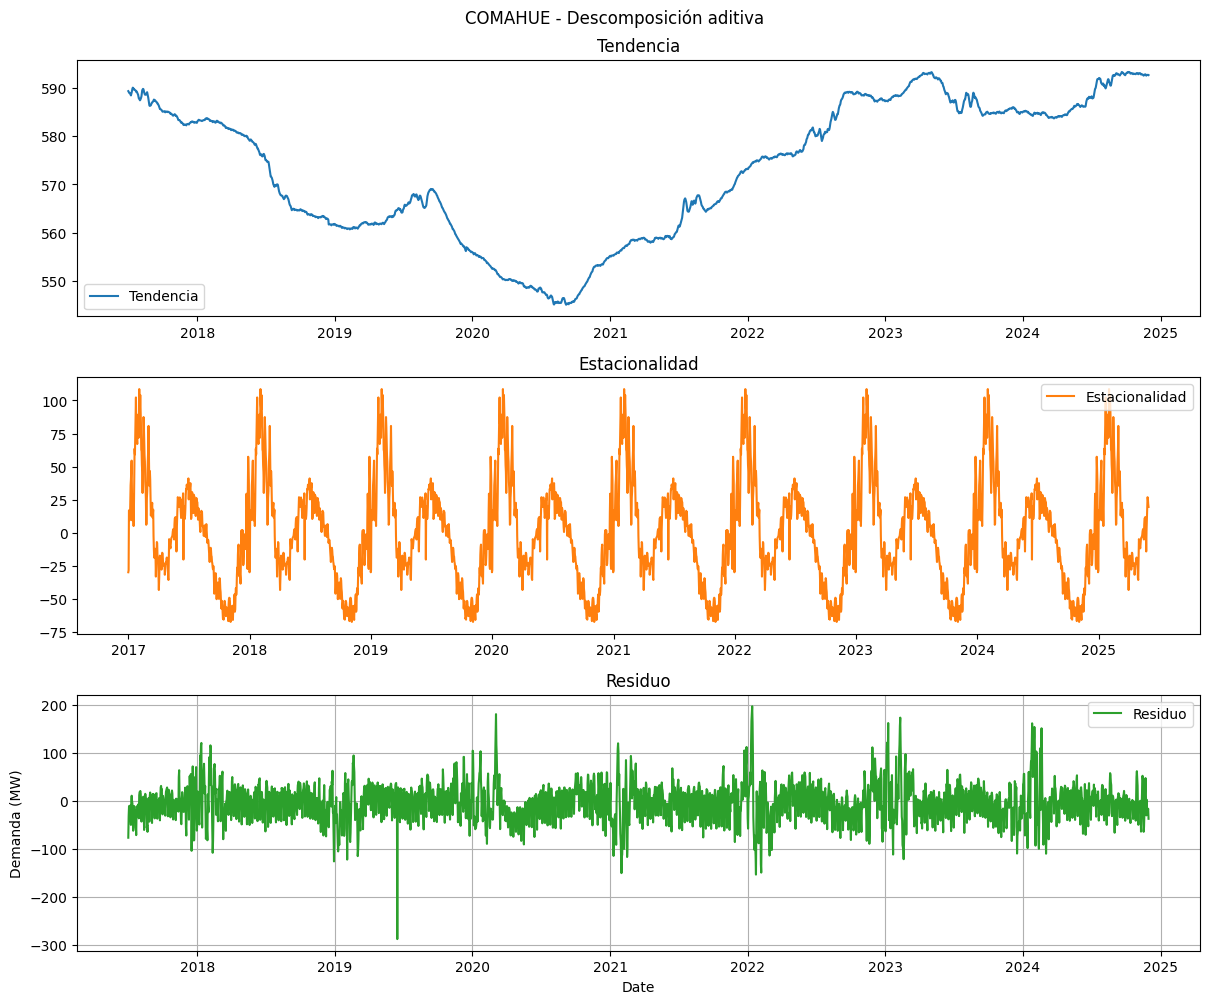

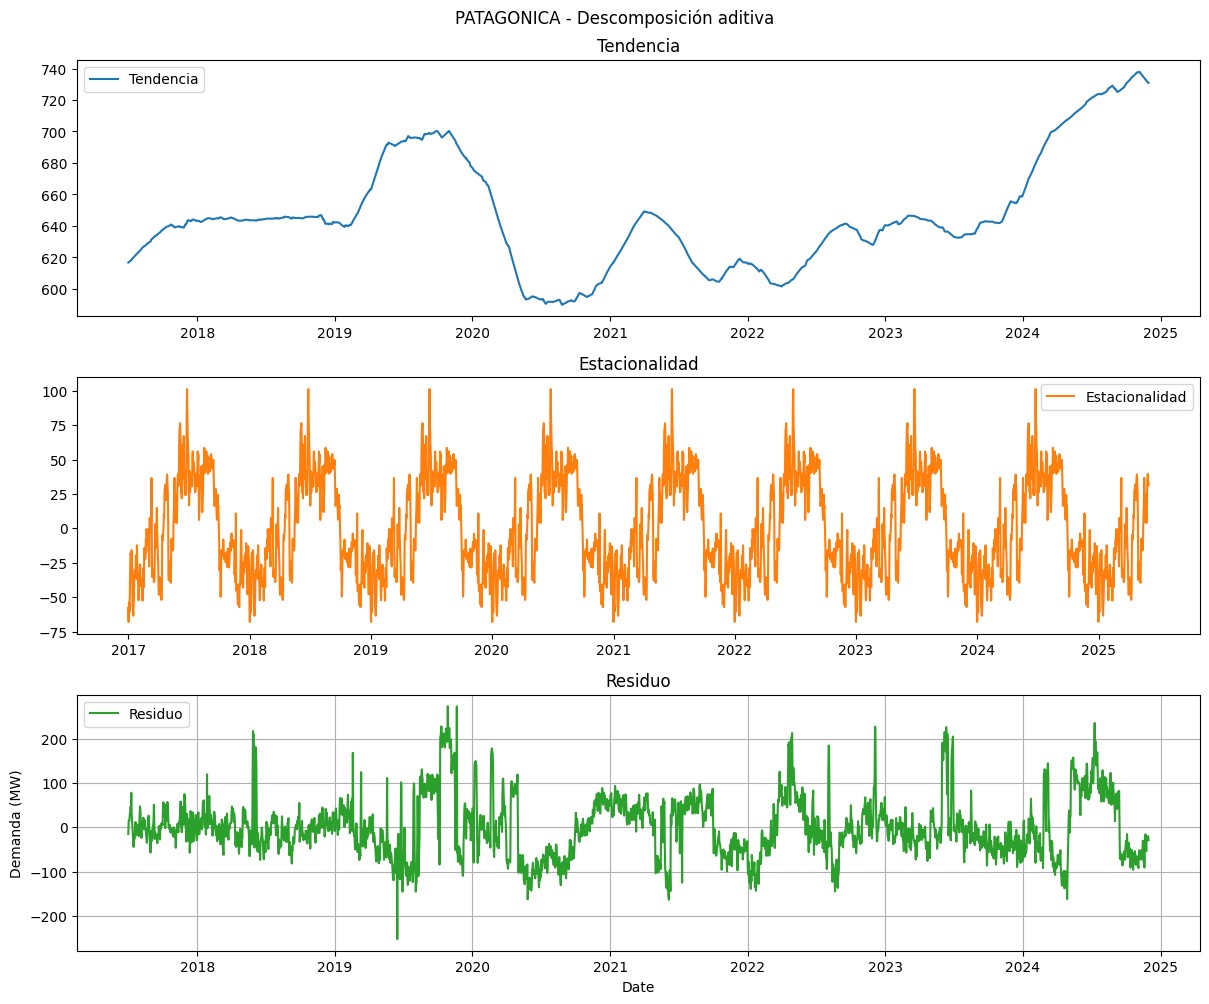

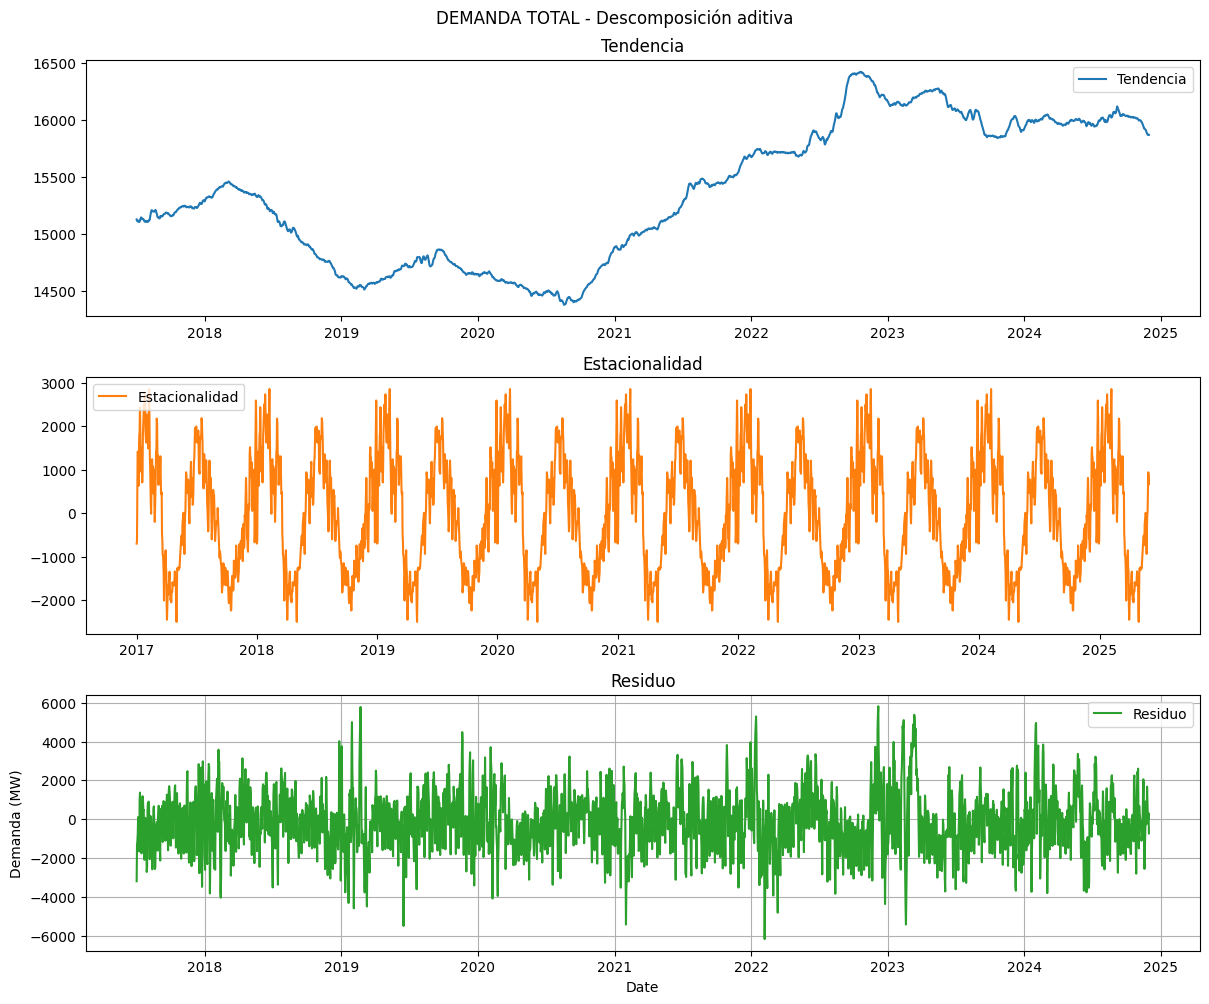

In [17]:
for col, serie in series.items():
    serie['DECOMPOSED'] = decompose_series(serie['ORIGINAL'], model='additive', period=365)
    plot_decomposition_2(serie['DECOMPOSED'], title=f"{col} - Descomposición aditiva")

# Prophet
### Utilizamos prophet sobre la serie MA30 de cada región.
### Podemos también utilizar la serie orignial.

In [18]:
for col, serie in series.items():
    serie['TRAIN'], serie['TEST'] = train_test_split(serie['MA30'], test_size=0.3)
    serie['PROPHET_MODEL'] = fit_prophet(serie['TRAIN'])
    serie['FORECAST_PROPHET'] = forecast_prophet(serie['PROPHET_MODEL'], periods=len(serie['TEST']), freq='D')

14:14:34 - cmdstanpy - INFO - Chain [1] start processing
14:14:35 - cmdstanpy - INFO - Chain [1] done processing
14:14:35 - cmdstanpy - INFO - Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:38 - cmdstanpy - INFO - Chain [1] done processing
14:14:38 - cmdstanpy - INFO - Chain [1] start processing
14:14:39 - cmdstanpy - INFO - Chain [1] done processing
14:14:40 - cmdstanpy - INFO - Chain [1] start processing
14:14:40 - cmdstanpy - INFO - Chain [1] done processing
14:14:41 - cmdstanpy - INFO - Chain [1] start processing
14:14:42 - cmdstanpy - INFO - Chain [1] done processing
14:14:42 - cmdstanpy - INFO - Chain [1] start processing
14:14:43 - cmdstanpy - INFO - Chain [1] done processing
14:14:44 - cmdstanpy - INFO - Chain [1] start processing
14:14:44 - cmdstanpy - INFO - Chain [1] done processing
14:14:45 - cmdstanpy - INFO - Chain [1] start processing
14:14:46 - cmdstanpy - INFO - Chain [1]

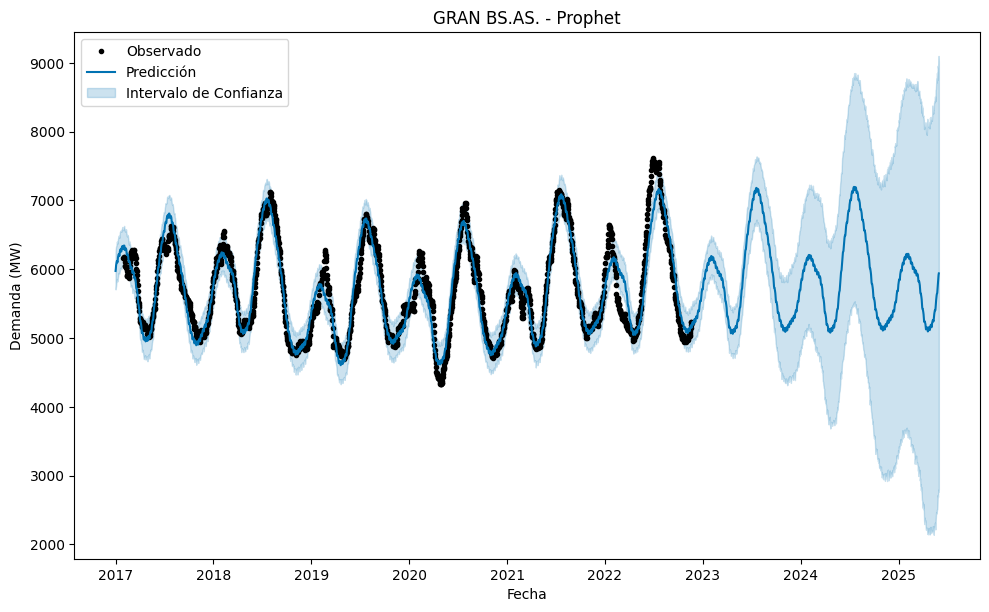

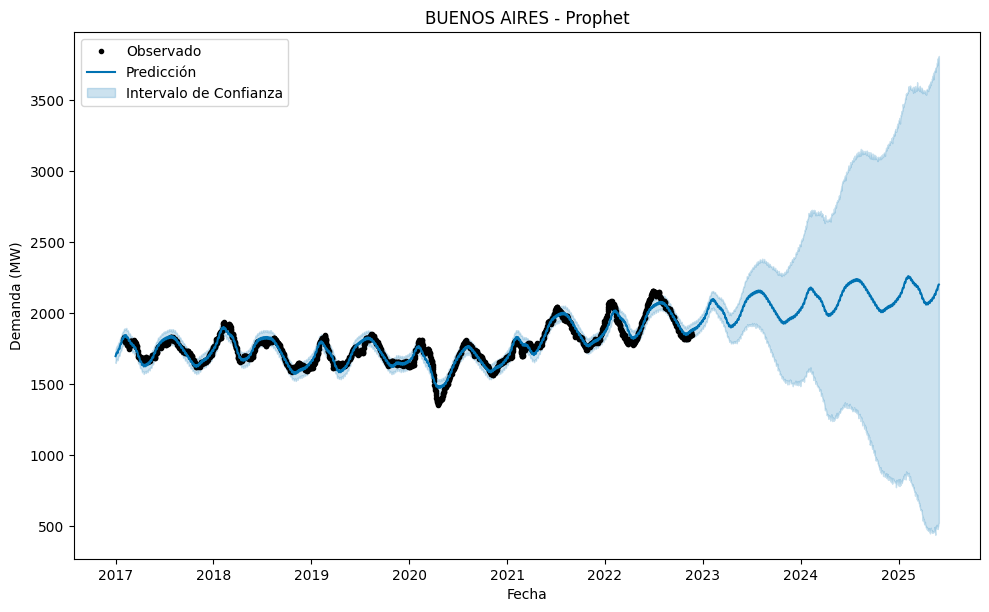

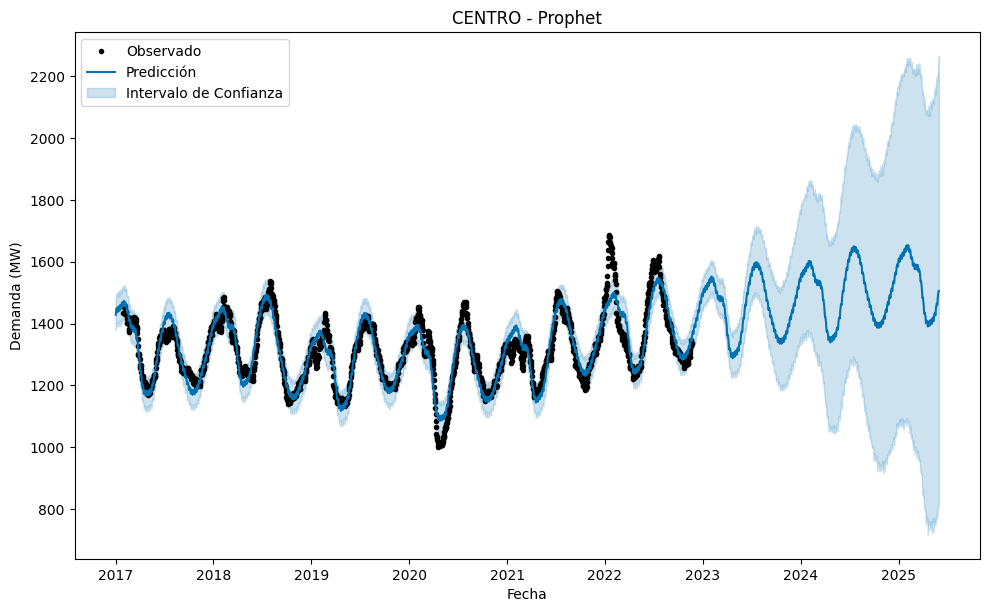

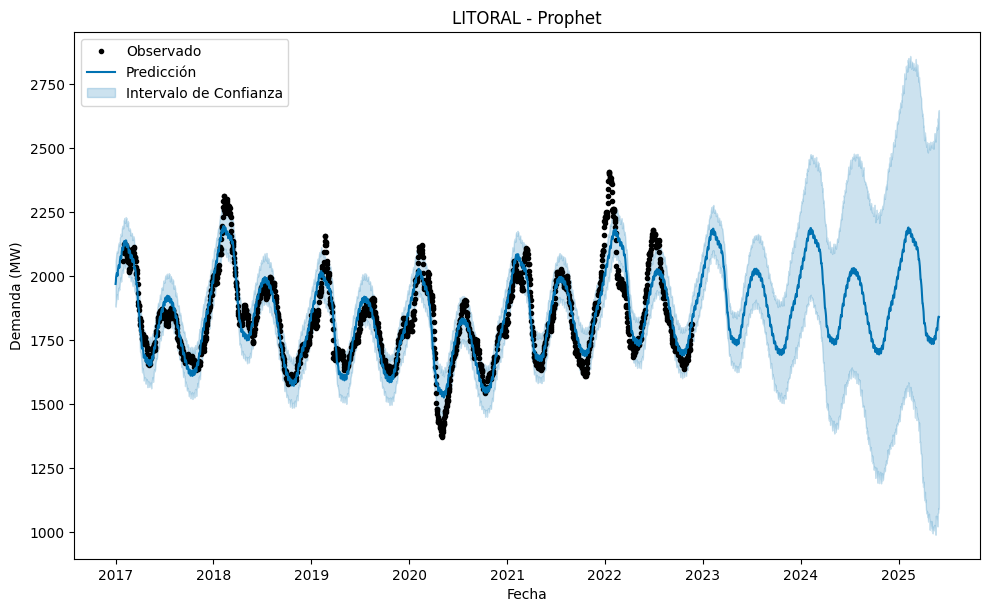

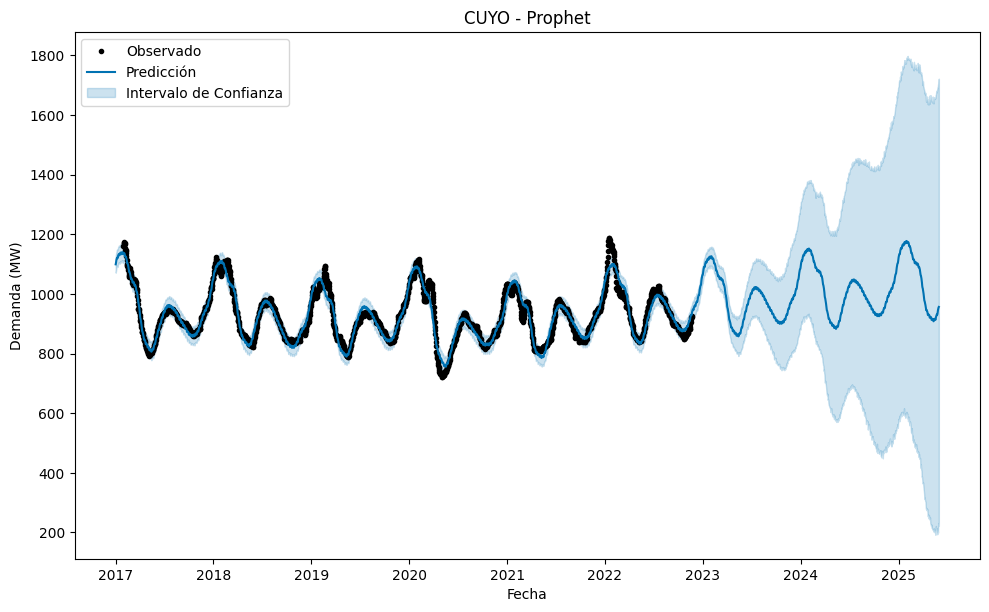

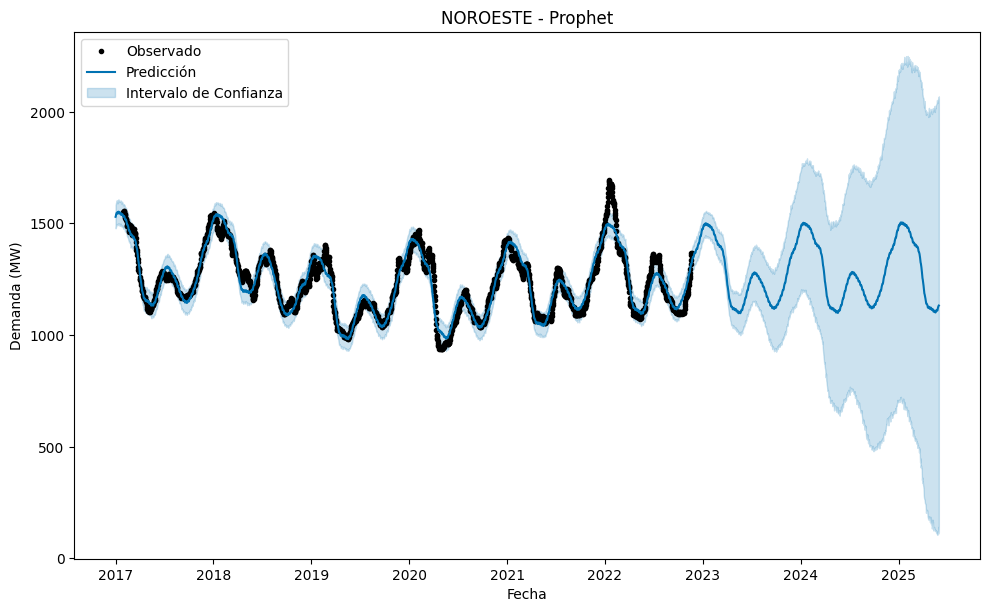

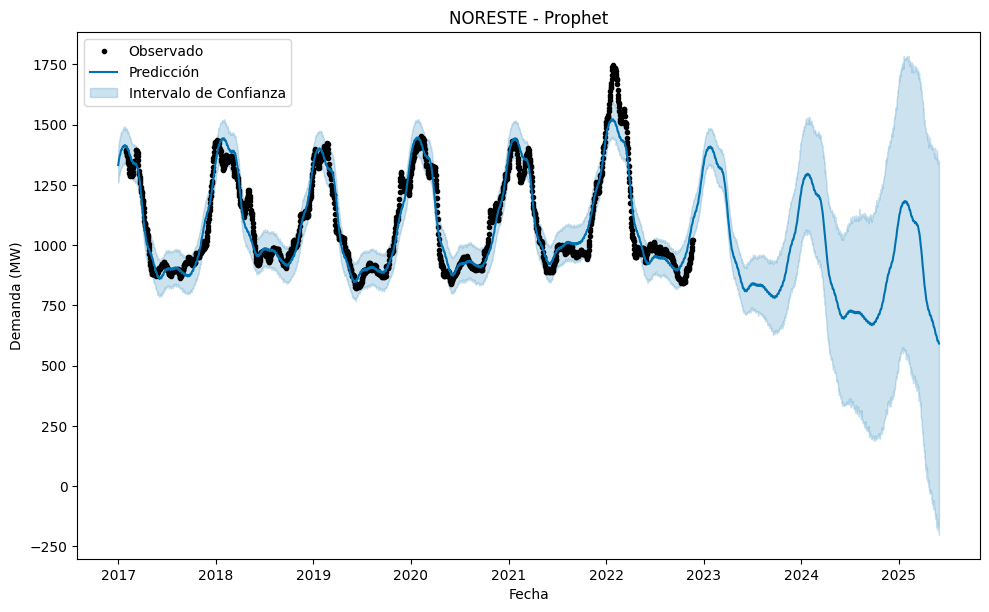

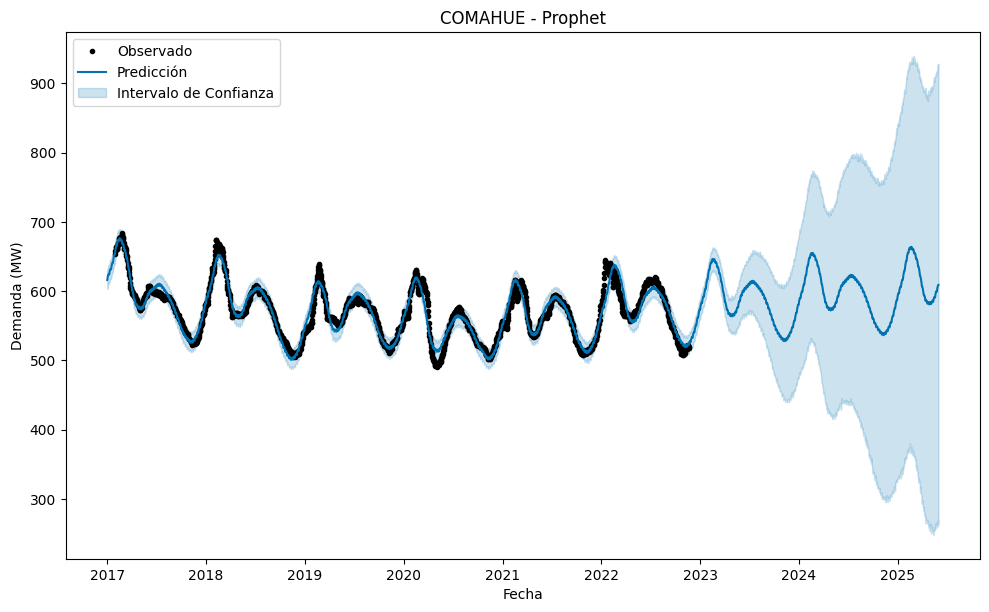

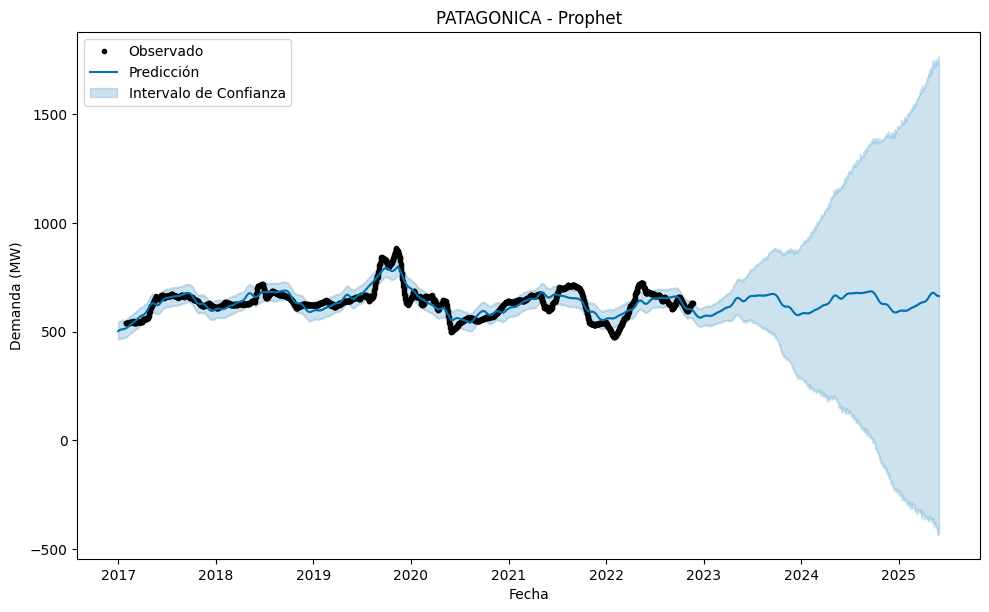

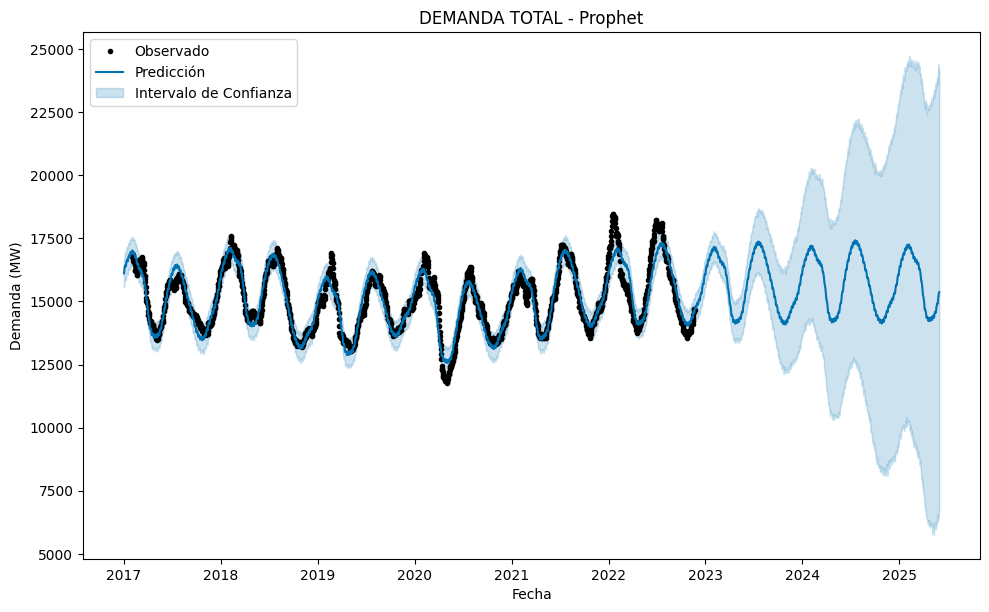

In [19]:
for col, serie in series.items():
    plot_forecast_prophet(model=serie['PROPHET_MODEL'],
                          forecast=serie['FORECAST_PROPHET'],
                          title=f"{col} - Prophet")

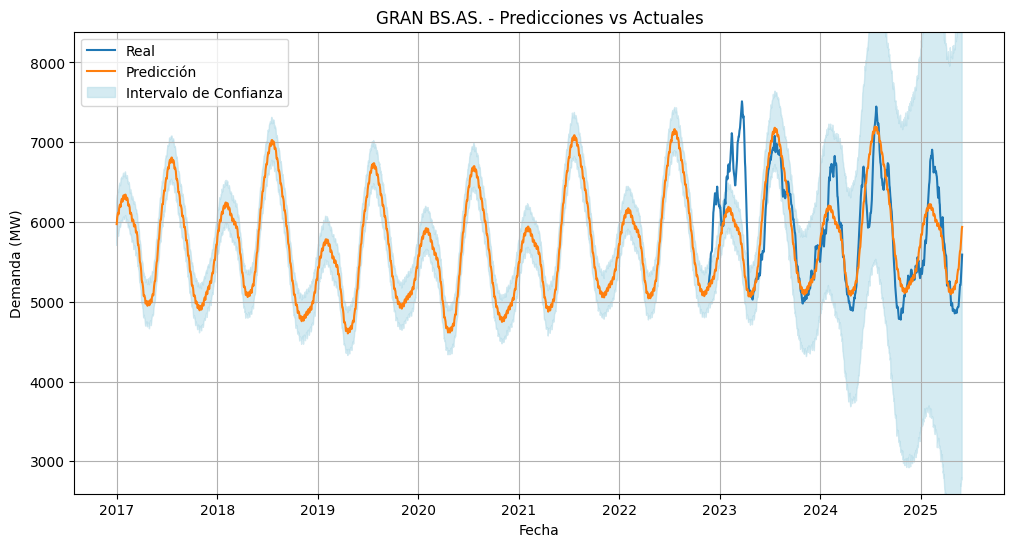

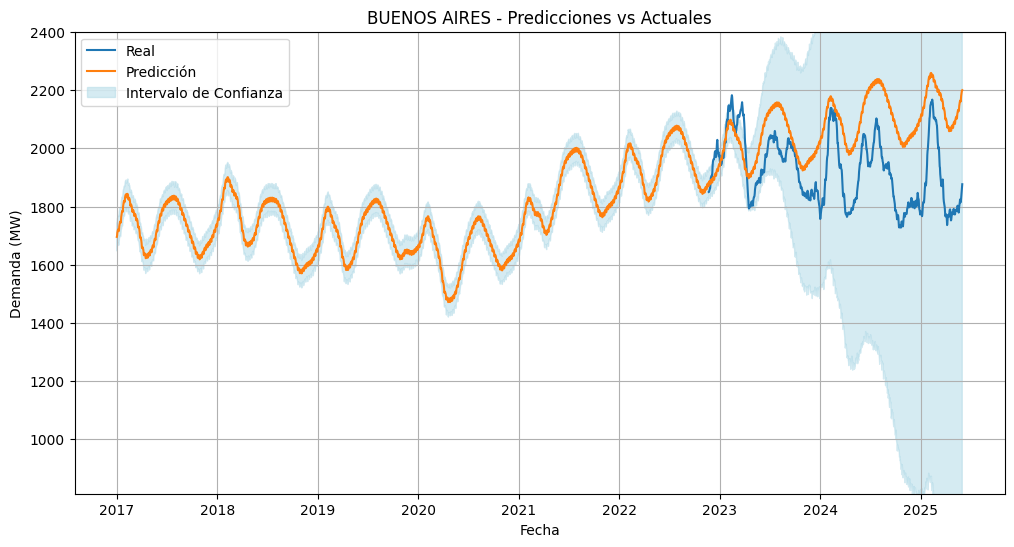

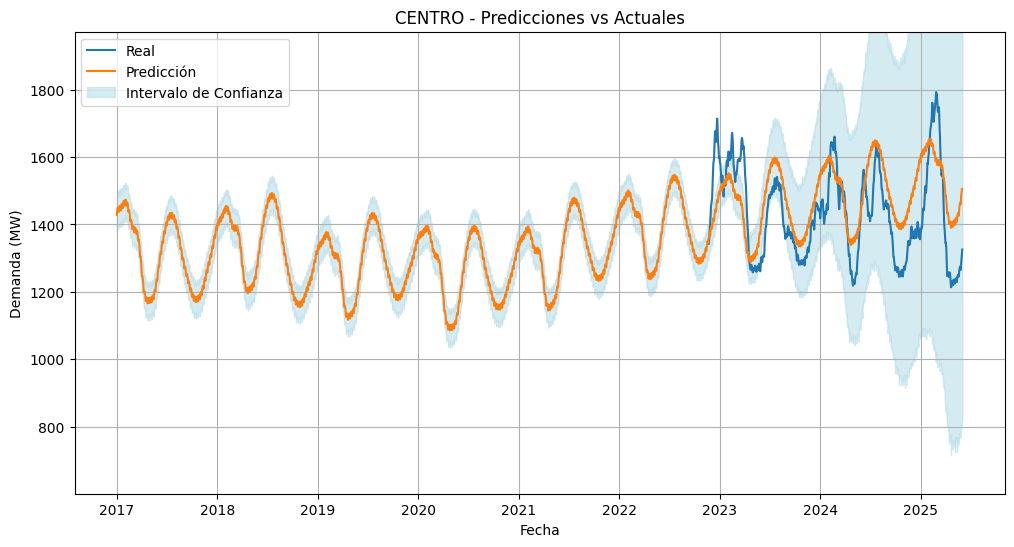

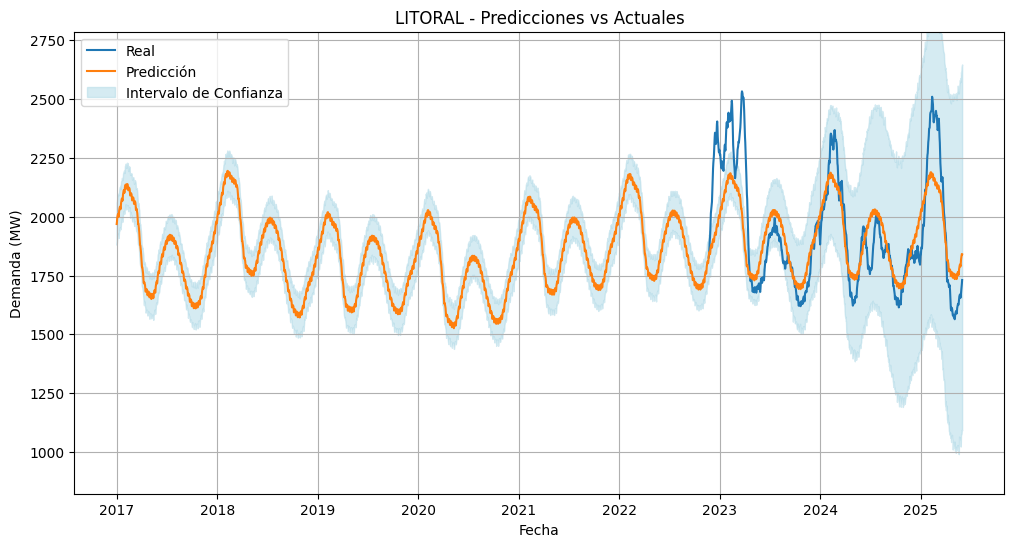

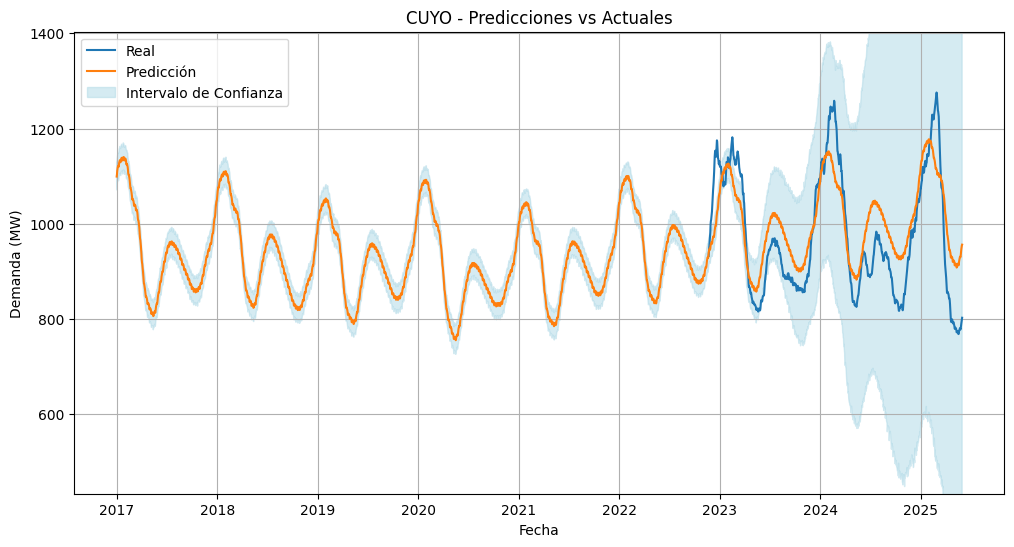

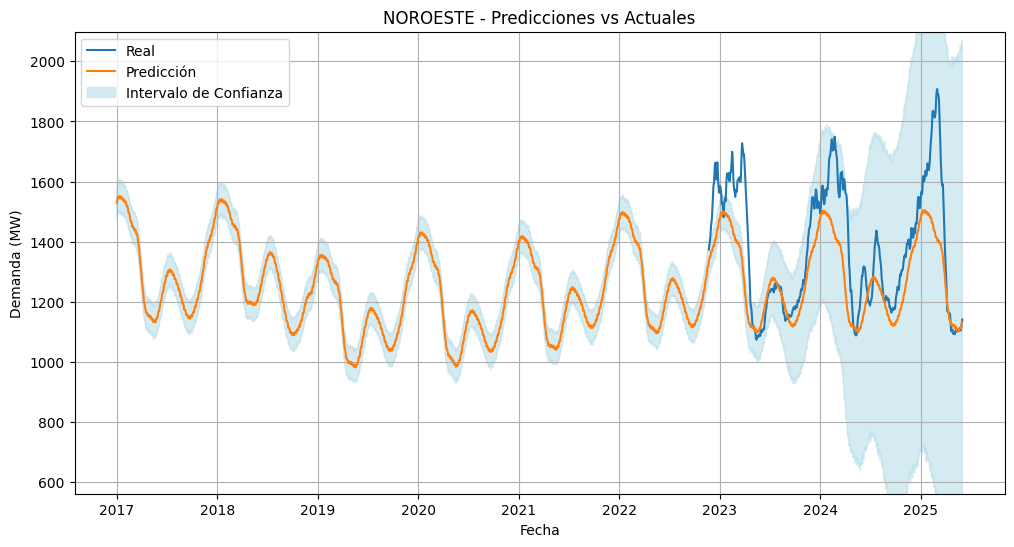

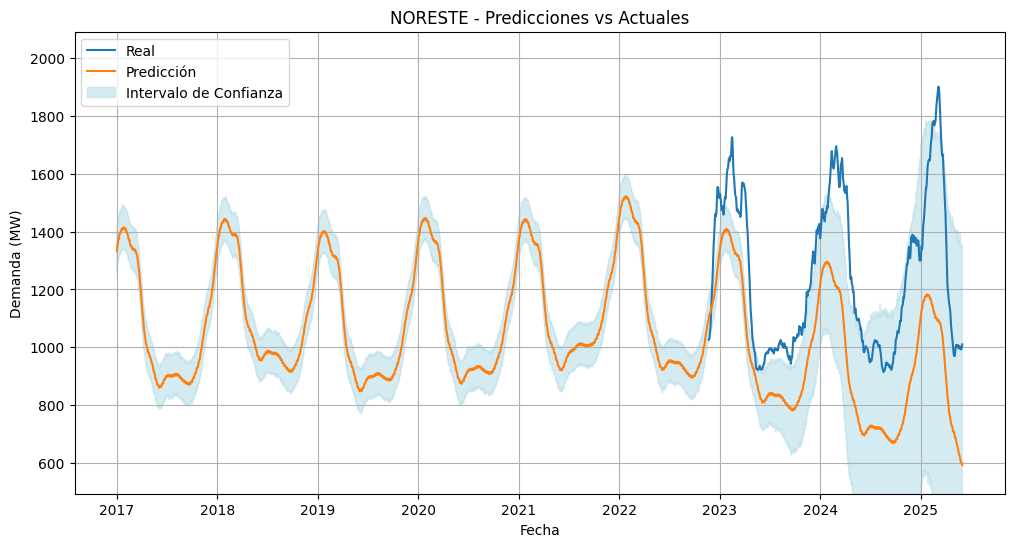

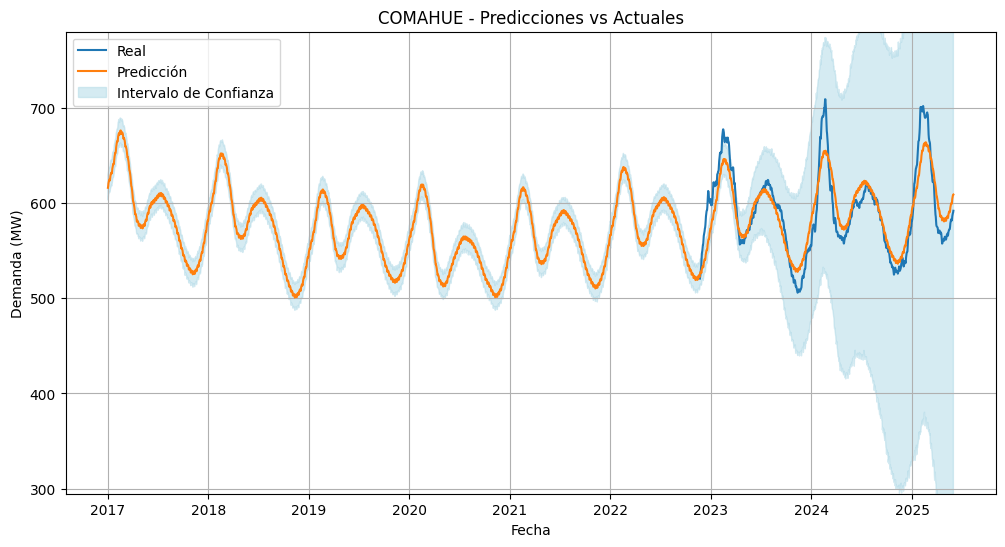

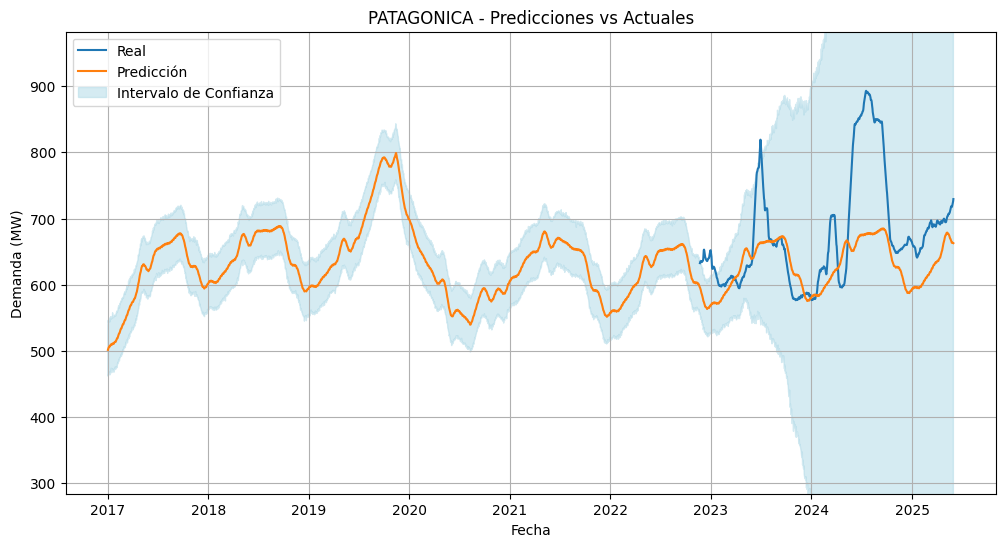

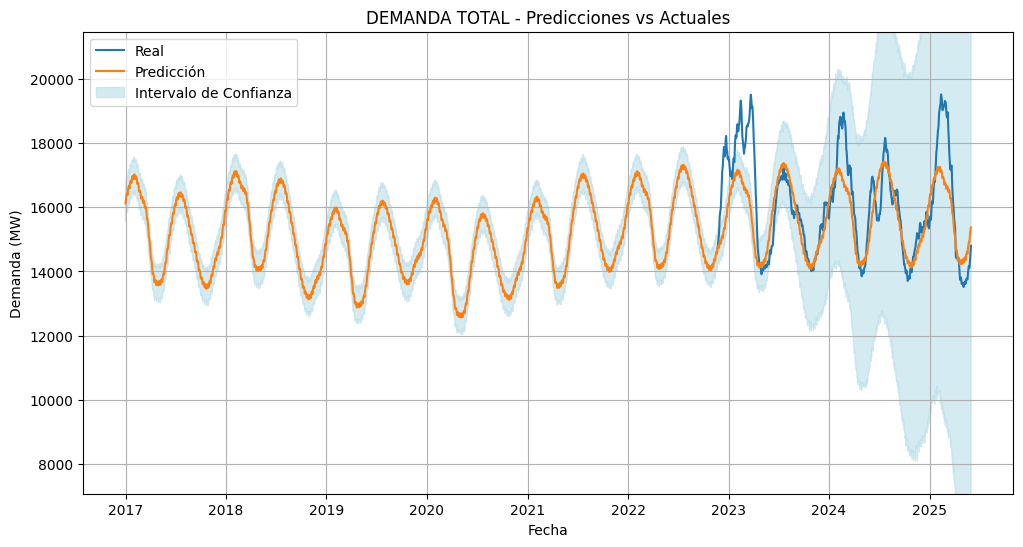

In [20]:
# Plot Prophet predictions vs actual data
for col, serie in series.items():
    plot_prophet_predictions_vs_actuals(forecast=serie['FORECAST_PROPHET'], 
                                        actuals=serie['TEST'], 
                                        title=f"{col} - Predicciones vs Actuales", 
                                        xlabel='Fecha', 
                                        ylabel='Demanda (MW)', 
                                        ymin=max(0, serie['MA30'].min() * 0.6), 
                                        ymax=serie['MA30'].max() * 1.1
                                        )

# TODO:
* [] Normalización gráficos (mismo mínimo/máximo) para facilitar la comparativa